# **1η εργαστηριακή άσκηση στα Νευρωνικά Δίκτυα - Μέρος 2. Kaggle dataset**


**Πάλμος Στέφανος el18185**

**Ντάγκας Παναγιώτης el18018**

**Νικόλαρος Ανδρέας el18401** 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import time
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
import seaborn as sns
# φέρνουμε τις γνωστές μας κλάσεις για preprocessing
from sklearn.feature_selection import VarianceThreshold # φέρνουμε τον StandarScaler ως transformer που έχει .transform kai ΄όχι ως scale()
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
import warnings
import time
import math
#from cuml.svm import SVC

In [2]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = ""
        else:
            stats_text = ""
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Εισαγωγή του Dataset

Το dataset που μας δόθηκε απεικονίζει όλα τα τροχαία ατυχήματα που έχουν συμβεί στη Γαλλία το έτος 2019. Αποτελείται από 4 csv αρχεία, 1 txt που δίνει σύντομη περιγραφή των στηλών, ένα pdf στα γαλλικά το οποίο περιγράφει τα csv και το πρόβλημα καθώς και μία εικόνα που κάνει τον ορισμό των θέσεων στα διάφορα οχήματα. Όπως φαίνεται και από τα ονόματα με τα οποία κάναμε την εισαγωγή το πρώτο csv έχει τα βασικά χαρατκηριστικά του ατυχήματος, το δεύτερο πληροφορίες για την τοποθεσία, το τρίτο για τους οδηγούς που συμμετείχαν και το τέταρτο για τα οχήματα. Τέλος από την περιγραφή των στηλών διαπιστώσαμε ότι σε όλες τα missing values δίνονται με την τιμή -1 άρα χρησιμοποιούμε την παράμετρο "na_values=-1" για να το δηλώσουμε αυτό στο διάβασμα και να αναγνωρίζεται από τις μετέπειτα συναρτήσεις 

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Read raw data
chars = pd.read_csv("../input/2019-database-of-road-traffic-injuries/caracteristiques-2019.csv",na_values=-1)
places = pd.read_csv("../input/2019-database-of-road-traffic-injuries/lieux-2019.csv",na_values=-1)
drivers = pd.read_csv("../input/2019-database-of-road-traffic-injuries/usagers-2019.csv",na_values=-1)
vehicles = pd.read_csv("../input/2019-database-of-road-traffic-injuries/vehicules-2019.csv",na_values=-1)

chars = chars.set_index('Num_Acc', drop=False)
places = places.set_index('Num_Acc', drop=False)
drivers = drivers.set_index('id_vehicule', drop=False)
vehicles = vehicles.set_index('id_vehicule', drop=False)

print("\nDataset characteristics has:", chars.shape[0], "rows and", chars.shape[1], "columns") 
print("Dataset places has:", places.shape[0], "rows and", places.shape[1], "columns") 
print("Dataset drivers has:", drivers.shape[0], "rows and", drivers.shape[1], "columns") 
print("Dataset vehicles has:", vehicles.shape[0], "rows and", vehicles.shape[1], "columns") 



/kaggle/input/2019-database-of-road-traffic-injuries/caracteristiques-2019.csv
/kaggle/input/2019-database-of-road-traffic-injuries/usagers-2019.csv
/kaggle/input/2019-database-of-road-traffic-injuries/vehicules-2019.csv
/kaggle/input/2019-database-of-road-traffic-injuries/Columns_Description.txt
/kaggle/input/2019-database-of-road-traffic-injuries/lieux-2019.csv
/kaggle/input/2019-database-of-road-traffic-injuries/Dataset Description with features (French).pdf
/kaggle/input/2019-database-of-road-traffic-injuries/Seats in vehicles.png

Dataset characteristics has: 58840 rows and 15 columns
Dataset places has: 58840 rows and 18 columns
Dataset drivers has: 132977 rows and 15 columns
Dataset vehicles has: 100710 rows and 11 columns


# Επισκόπηση του Dataset

In [4]:
print("\nChar info: ")
print(chars.info())
missing_char=chars.isna().sum()
missing_char=pd.DataFrame(missing_char)
print("\nThe following columns have over 60% missing values:")
drop_char=list(missing_char[missing_char[0].map(lambda x:x>=60*len(chars.index)/100)].index)
print(drop_char)

char = chars.drop(columns = drop_char)
char=char[char["Num_Acc"].map(lambda x:type(x) == int or len(x)==12)]


Char info: 
<class 'pandas.core.frame.DataFrame'>
Index: 58840 entries, 201900000001 to 201900058840
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Num_Acc  58840 non-null  object 
 1   jour     58713 non-null  float64
 2   mois     58713 non-null  float64
 3   an       58713 non-null  float64
 4   hrmn     58713 non-null  float64
 5   lum      58713 non-null  float64
 6   dep      58713 non-null  object 
 7   com      58713 non-null  object 
 8   agg      58713 non-null  float64
 9   int      58713 non-null  float64
 10  atm      58712 non-null  float64
 11  col      58711 non-null  float64
 12  adr      58286 non-null  object 
 13  lat      58713 non-null  float64
 14  long     58713 non-null  float64
dtypes: float64(11), object(4)
memory usage: 7.2+ MB
None

The following columns have over 60% missing values:
[]


Σχετικά με το csv με τα χαρακτηριστικά των ατυχηματων αυτό αποτελείται από τις εξής στήλες:
> -Num_Acc(αύξων αριθμός αναγνώρισης του τροχαίου-object)

> -jour(μέρα του ατυχήματος-float)

> -mois(μήνας του ατυχήματος-float)

> -an(έτος του ατυχήματος-float)

> -hrmn(ώρα και λεπτά του ατυχήματος-float)

> -lum(φως την ώρα του ατυχήματος. Μη διατεταγμένο χαρατκηριστικό καθώς δίνεται με νούμερα απο το 1 έως το 5-float)

> -dep(κωδικός γεωγραφικού διαμερίσματος-object)

> -com(κωδικός περιοχής-object)

> -agg(χαρακτηριστικό με τιμή 1 ή 2 ανάλογα με το αν το ατύχημα έγινε εντός ή εκτος κατοικημένης περιοχής αντίστοιχα-float)

> -int(περιγραφή του κόμβου που έγινε το ατύχημα. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται με αριθμούς από το 1 έως το 8-float)

> -atm(καιρικές συνθήκες την ώρα του ατυχήματος. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 1 έως το 9-float)

> -col(τύπος σύγκρουσης. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 1 έως το 7-float)

> -adr(ταχυδρομικός κώδικας-object)

> -lat(γεωγραφικό πλατος-float)

> -long(γεωγραφικό μήκος-float)

Αφού δούμε τον τύπο όλων των χαρατκηριστικών αναζητούμε αν υπάρχει κάποια στήλη με πάνω απο 60% missing values ούτως ώστε να την αφαιρέσουμε και βλέπουμε ότι δεν υπάρχει καμία.

In [5]:
print("\nPlaces info: ")
print(places.info())
missing_places=places.isna().sum()
missing_places=pd.DataFrame(missing_places)
print("\nThe following columns have over 60% missing values:")
drop_places=list(missing_places[missing_places[0].map(lambda x:x>=60*len(places.index)/100)].index)
print(drop_places)

places = places.drop(columns = drop_places)
places=places[places["Num_Acc"].map(lambda x:type(x) == int or len(x)==12)]


Places info: 
<class 'pandas.core.frame.DataFrame'>
Index: 58840 entries, 201900000001 to 201900058840
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Num_Acc  58840 non-null  object 
 1   catr     58814 non-null  float64
 2   voie     55879 non-null  object 
 3   v1       48068 non-null  float64
 4   v2       4167 non-null   object 
 5   circ     55669 non-null  float64
 6   nbv      58164 non-null  float64
 7   vosp     58145 non-null  float64
 8   prof     58800 non-null  float64
 9   pr       51517 non-null  float64
 10  pr1      51215 non-null  float64
 11  plan     58803 non-null  float64
 12  lartpc   211 non-null    float64
 13  larrout  372 non-null    float64
 14  surf     58793 non-null  float64
 15  infra    58769 non-null  float64
 16  situ     58698 non-null  float64
 17  vma      57933 non-null  float64
dtypes: float64(15), object(3)
memory usage: 8.5+ MB
None

The following columns have over 60% missing 

Σχετικά με το csv με τα χαρακτηριστικά των μερών αυτό αποτελείται από τις εξής στήλες:

> -Num_Acc(αύξων αριθμός αναγνώρισης του τροχαίου-object)
> 
> -catr(είδος δρόμου. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 1 έως το 9-float)
> 
> -voie(αριθμός δρόμου-object)
> 
> -v1(αριθμός δρόμου-float)
> 
> -v2(αλφαριθμητικό χαρακτηριστικό ταυτότητας δρόμου-object)
> 
> -circ(χαρακτηριστικό που περιγράφει αν ο δρόμος είναι μονής ή διπλής κατευθύνσης ή έχει διάζωμα στη μέση ή κατι διαφορετικό. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 1 έως το 4-float)
> 
> -nbv(αριθμός λωρίδων κυκλοφορίας-float
> 
> -vosp(χαρακτηριστικό για την ύπαρξη έξτρα λωρίδας. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 0 έως το 3-float)
> 
> -prof(γεωγραφικό προφίλ περιοχής δηλαδή αν είναι επίπεδο, λόφος, έχει κλίση ή είναι στην ακτογραμμή. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 1 έως το 4-float)
> 
> -pr(αριθμός αρμόδιου τμήματος-float)
> 
> -pr1(απόσταση σε μέτρα από το αρμόδιο τμήμα-float)
> 
> -plan(χαρακτηριστικό για το αν έγινε σε στροφή ή ευθεία. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 1 έως το 4-float)
> 
> -lartpc(πλάτος λεα αν υπάρχει-float)
> 
> -larrout(πλάτος υπόλοιπων λωρίδων-float)
> 
> -surf(κατάσταση οδοστρώματος. χαρακτηριστικό για το αν έγινε σε στροφή ή ευθεία. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 1 έως το 9-float)
> 
> -infra(χαρακτηριστικά δρόμου και υποδομών. χαρακτηριστικό για το αν έγινε σε στροφή ή ευθεία. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 0 έως το 9)
> 
> -situ(σε ποιο σημείο του δρόμου έγινε το ατύχημα. χαρακτηριστικό για το αν έγινε σε στροφή ή ευθεία. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 0 έως το 8)
> 
> -vma(όριο ταχύτητας-float)

Αφού δούμε τον τύπο όλων των χαρατκηριστικών αναζητούμε αν υπάρχει κάποια στήλη με πάνω απο 60% missing values ούτως ώστε να την αφαιρέσουμε και βλέπουμε ότι υπάρχουν οι v2, larrtpc και larrout τις οποίες και κάνουμε drop καθώς είναι στην πλειοψηφία τους απουσιάζουσες τιμές.

In [6]:
print("\nDrivers info: ")
print(drivers.info())
missing_drivers=drivers.isna().sum()
missing_drivers=pd.DataFrame(missing_drivers)
print("\nThe following columns have over 60% missing values:")
drop_dr=list(missing_drivers[missing_drivers[0].map(lambda x:x>=60*len(drivers.index)/100)].index)
print(drop_dr)

drivers = drivers.drop(columns = drop_dr)


Drivers info: 
<class 'pandas.core.frame.DataFrame'>
Index: 132977 entries, 138 306 524 to 137 982 130
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      132977 non-null  int64  
 1   id_vehicule  132977 non-null  object 
 2   num_veh      132977 non-null  object 
 3   place        132977 non-null  int64  
 4   catu         132977 non-null  int64  
 5   grav         132977 non-null  int64  
 6   sexe         132977 non-null  int64  
 7   an_nais      132977 non-null  int64  
 8   trajet       132434 non-null  float64
 9   secu1        132889 non-null  float64
 10  secu2        92813 non-null   float64
 11  secu3        1754 non-null    float64
 12  locp         82504 non-null   float64
 13  actp         106636 non-null  object 
 14  etatp        11057 non-null   float64
dtypes: float64(6), int64(6), object(3)
memory usage: 16.2+ MB
None

The following columns have over 60% missing values:
['secu3', '

Σχετικά με το csv με τα χαρακτηριστικά των ατόμων αυτό αποτελείται από τις εξής στήλες:

> -Num_Acc(αύξων αριθμός αναγνώρισης του τροχαίου-int)
> 
> -id_vehicule(ταυτότητα οχήματος-object)
> 
> -Num_veh(αναγνωριστικό οχήματος-object)
> 
> -place(θέση κάθε επιβάτη. Δίνεται επεξήγηση στην εικόνα png-int)
> 
> -catu(ιδιότητα δηλαδή αν ήταν ο οδηγός, απλός επιβάτης ή πεζός. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 1 έως το 9-int)
> 
> -grav(σφοδρότητα τραυματισμού. Το label του dataset-int)
> 
> -sexe(φύλο-int)
> 
> -an_nais(έτος γέννησης-int)
> 
> -trajet(λόγος μετακίνησης. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 0 έως το 9-float)
> 
> -secu1(πρώτο μέτρο ασφαλείας αυτοκινήτου. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 1 έως το 9-float)
> 
> -secu2(δεύτερο μέτρο ασφαλείας αυτοκινήτου. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 1 έως το 9-float)
> 
> -secu3(τρίτο μέτρο ασφαλείας αυτοκινήτου. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 1 έως το 9-float)
> 
> -locp(θέση πεζού. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 0 έως το 9-float)
> 
> -actp(δράση πεζού. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 0 έως το 9 ενώ έχει και τους χαρακτήρες Α και Β.-object)
> 
> -etatp(χαρακτηριτικό που περιγράφει αν ο τραυματισμένος πεζός ήταν μόνος του ή συνοδευόταν. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 1 έως το 3-float)

Αφού δούμε τον τύπο όλων των χαρατκηριστικών αναζητούμε αν υπάρχει κάποια στήλη με πάνω απο 60% missing values ούτως ώστε να την αφαιρέσουμε και βλέπουμε ότι υπάρχουν οι secu3 και etatp τις οποίες και κάνουμε drop καθώς είναι στην πλειοψηφία τους απουσιάζουσες τιμές.

In [7]:
print("\nVehicles info: ")
print(vehicles.info())
missing_veh=vehicles.isna().sum()
missing_veh=pd.DataFrame(missing_veh)
print("\nThe following columns have over 60% missing values:")
drop_veh=list(missing_veh[missing_veh[0].map(lambda x:x>=60*len(vehicles.index)/100)].index)
print(drop_veh)

vehicles = vehicles.drop(columns = drop_veh)


Vehicles info: 
<class 'pandas.core.frame.DataFrame'>
Index: 100710 entries, 138 306 524 to 137 982 130
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      100710 non-null  int64  
 1   id_vehicule  100710 non-null  object 
 2   num_veh      100710 non-null  object 
 3   senc         100668 non-null  float64
 4   catv         100710 non-null  int64  
 5   obs          100669 non-null  float64
 6   obsm         100636 non-null  float64
 7   choc         100665 non-null  float64
 8   manv         100666 non-null  float64
 9   motor        100384 non-null  float64
 10  occutc       892 non-null     float64
dtypes: float64(7), int64(2), object(2)
memory usage: 9.2+ MB
None

The following columns have over 60% missing values:
['occutc']


Σχετικά με το csv με τα χαρακτηριστικά των ατόμων αυτό αποτελείται από τις εξής στήλες:

> -Num_Acc(αύξων αριθμός αναγνώρισης του τροχαίου-int)
> 
> -id_vehicule(ταυτότητα οχήματος-object)
> 
> -Num_veh(αναγνωριστικό οχήματος-object)
> 
> -senc(κατεύθυνση ροής οχημάτων. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 0 έως το 3-float)
> 
> -catv(κατηγορία οχήματος. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 00 έως το 99-int)
> 
> -obs(τύπος ακίνητου εμποδίου πρόσκρουσης. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 00 έως το 17-float)
> 
> -obsm(τύπος εμποδίου πρόσκρουσηςσε κίνηση. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 0 έως το 9-float)
> 
> -choc(σημείο πρόσκρουσης-Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 0 έως το 9-float)
> 
> -manv(βασική κίνηση οχήματος πριν την πρόσκορυση. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 0 έως το 26-float)
> 
> -motor(τύπος μηχανής οχήματος. Μη διατεταγμένο χαρακτηριστικό καθώς δίνεται από έναν αριθμό από το 0 έως το 6-float)
> 
> -occutc(αριθμός επιβατών αν αναφέρεταιη γραμμή σε ΜΜΜ-float)
> 
Αφού δούμε τον τύπο όλων των χαρατκηριστικών αναζητούμε αν υπάρχει κάποια στήλη με πάνω απο 60% missing values ούτως ώστε να την αφαιρέσουμε και βλέπουμε ότι υπάρχει η occutc την οποία και κάνουμε drop καθώς είναι στην πλειοψηφία της απουσιάζουσες τιμές.

Στη συνέχεια αποφασίσαμε να εκτυπώσουμε την κατανομή τιμών για όσα χαρακτηριστικά έχουν τιμές int και float καθώς και να τυπώσουμε τη συχνότητα εμφάνισης κάθε instance για χαρακτηριστικά τύπου object ούτως ώστε να έχουμε εικόνα της κατανομής των τιμών τους.

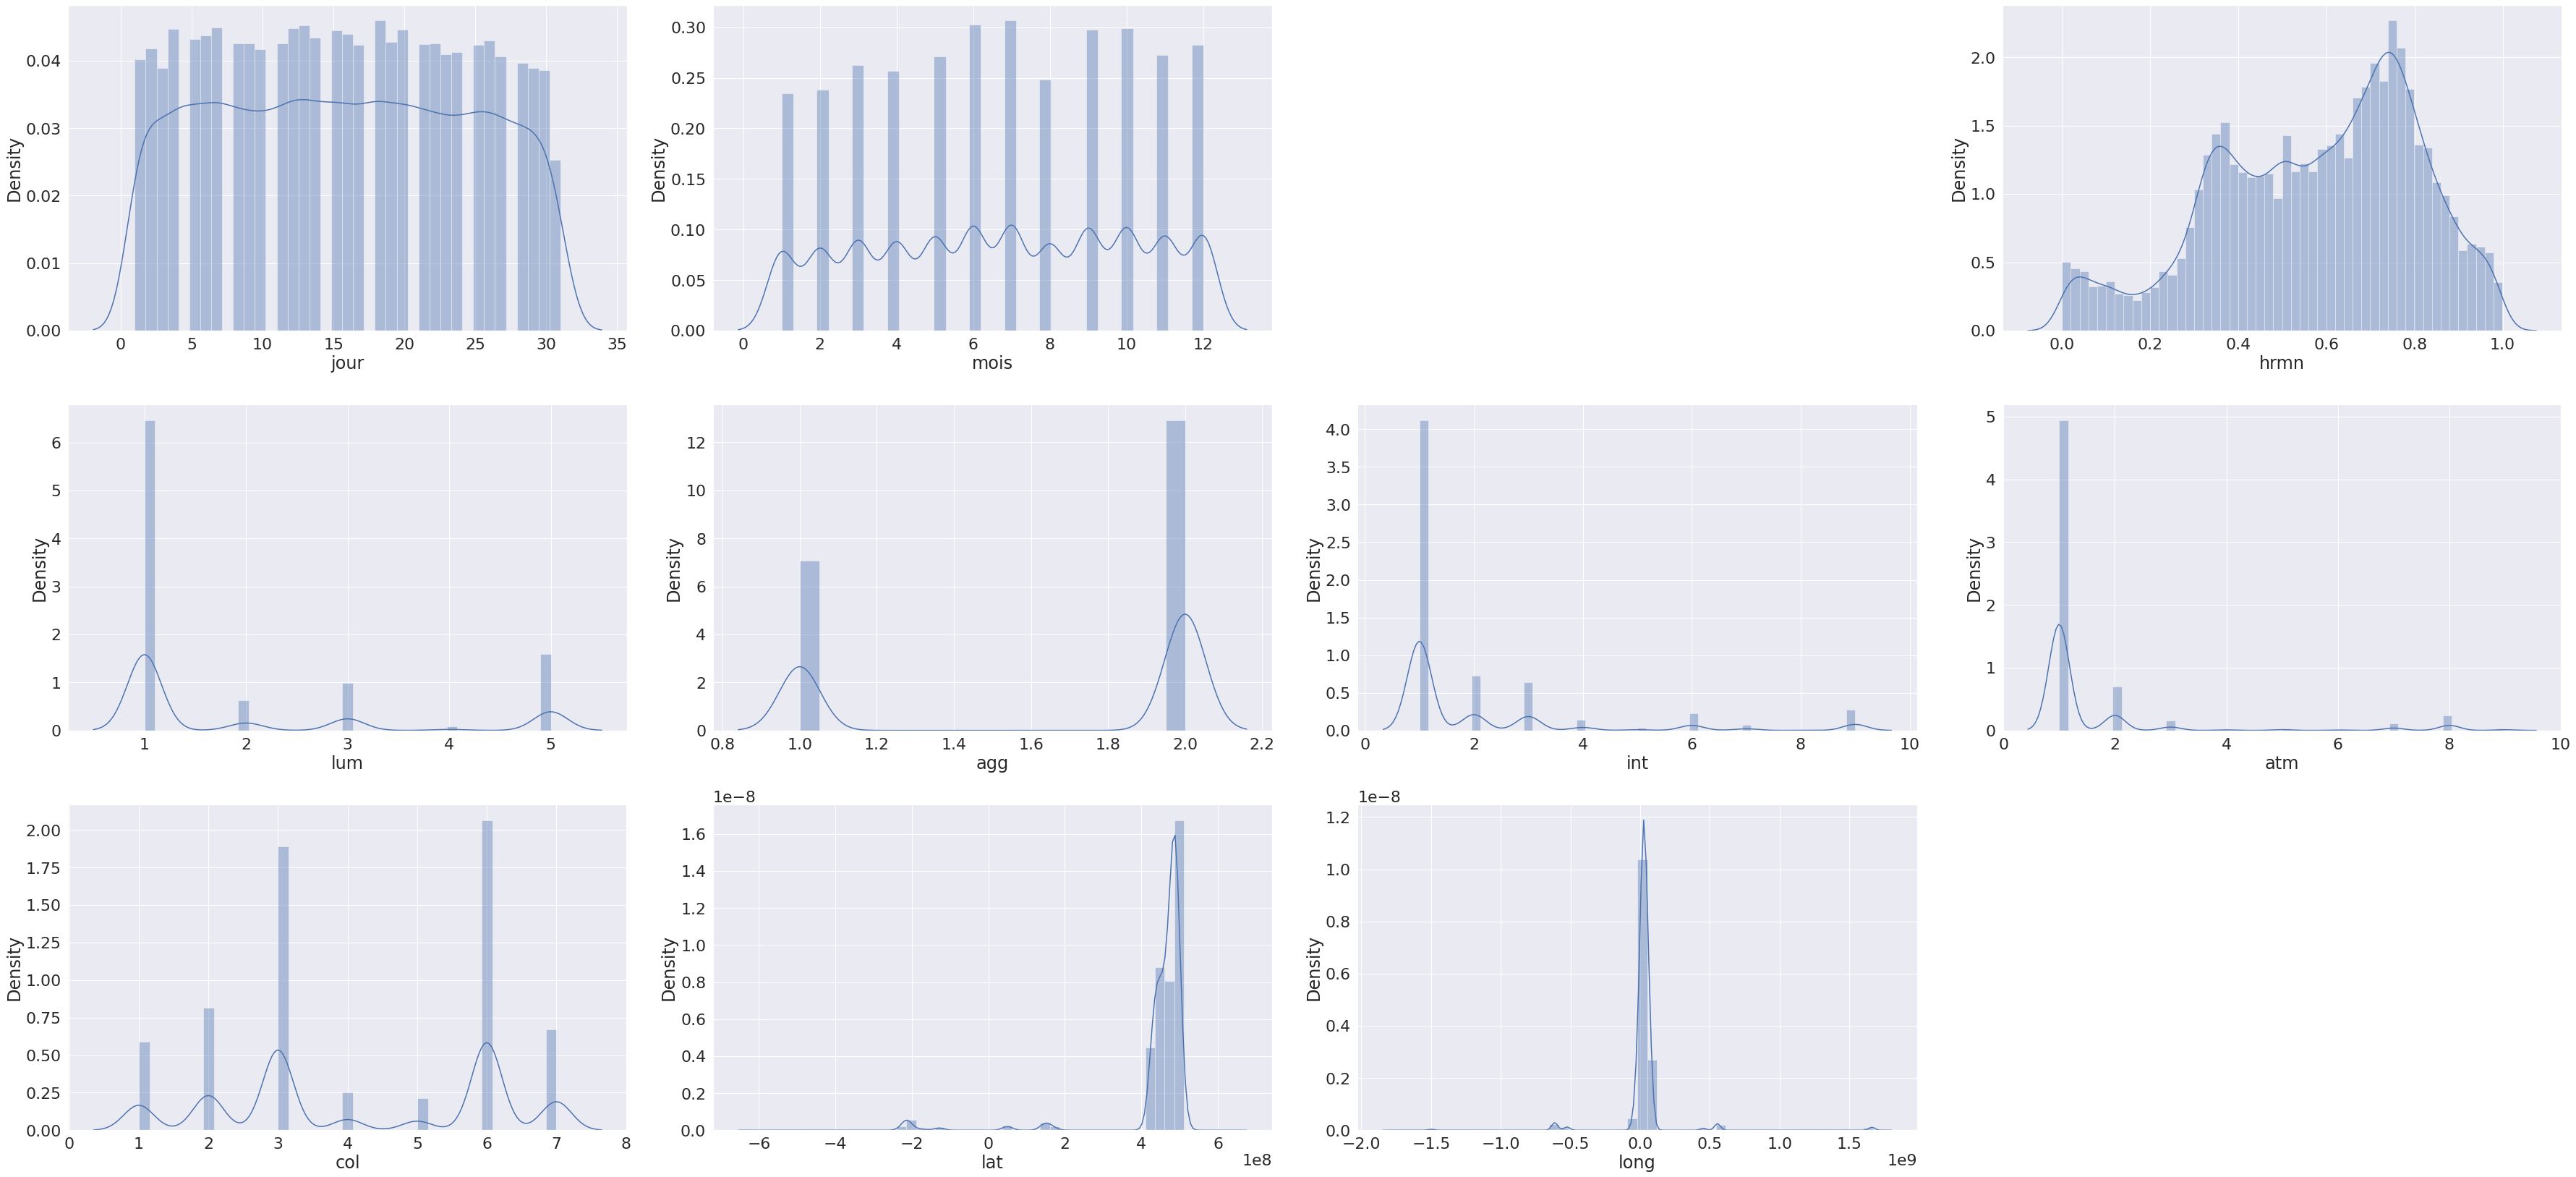

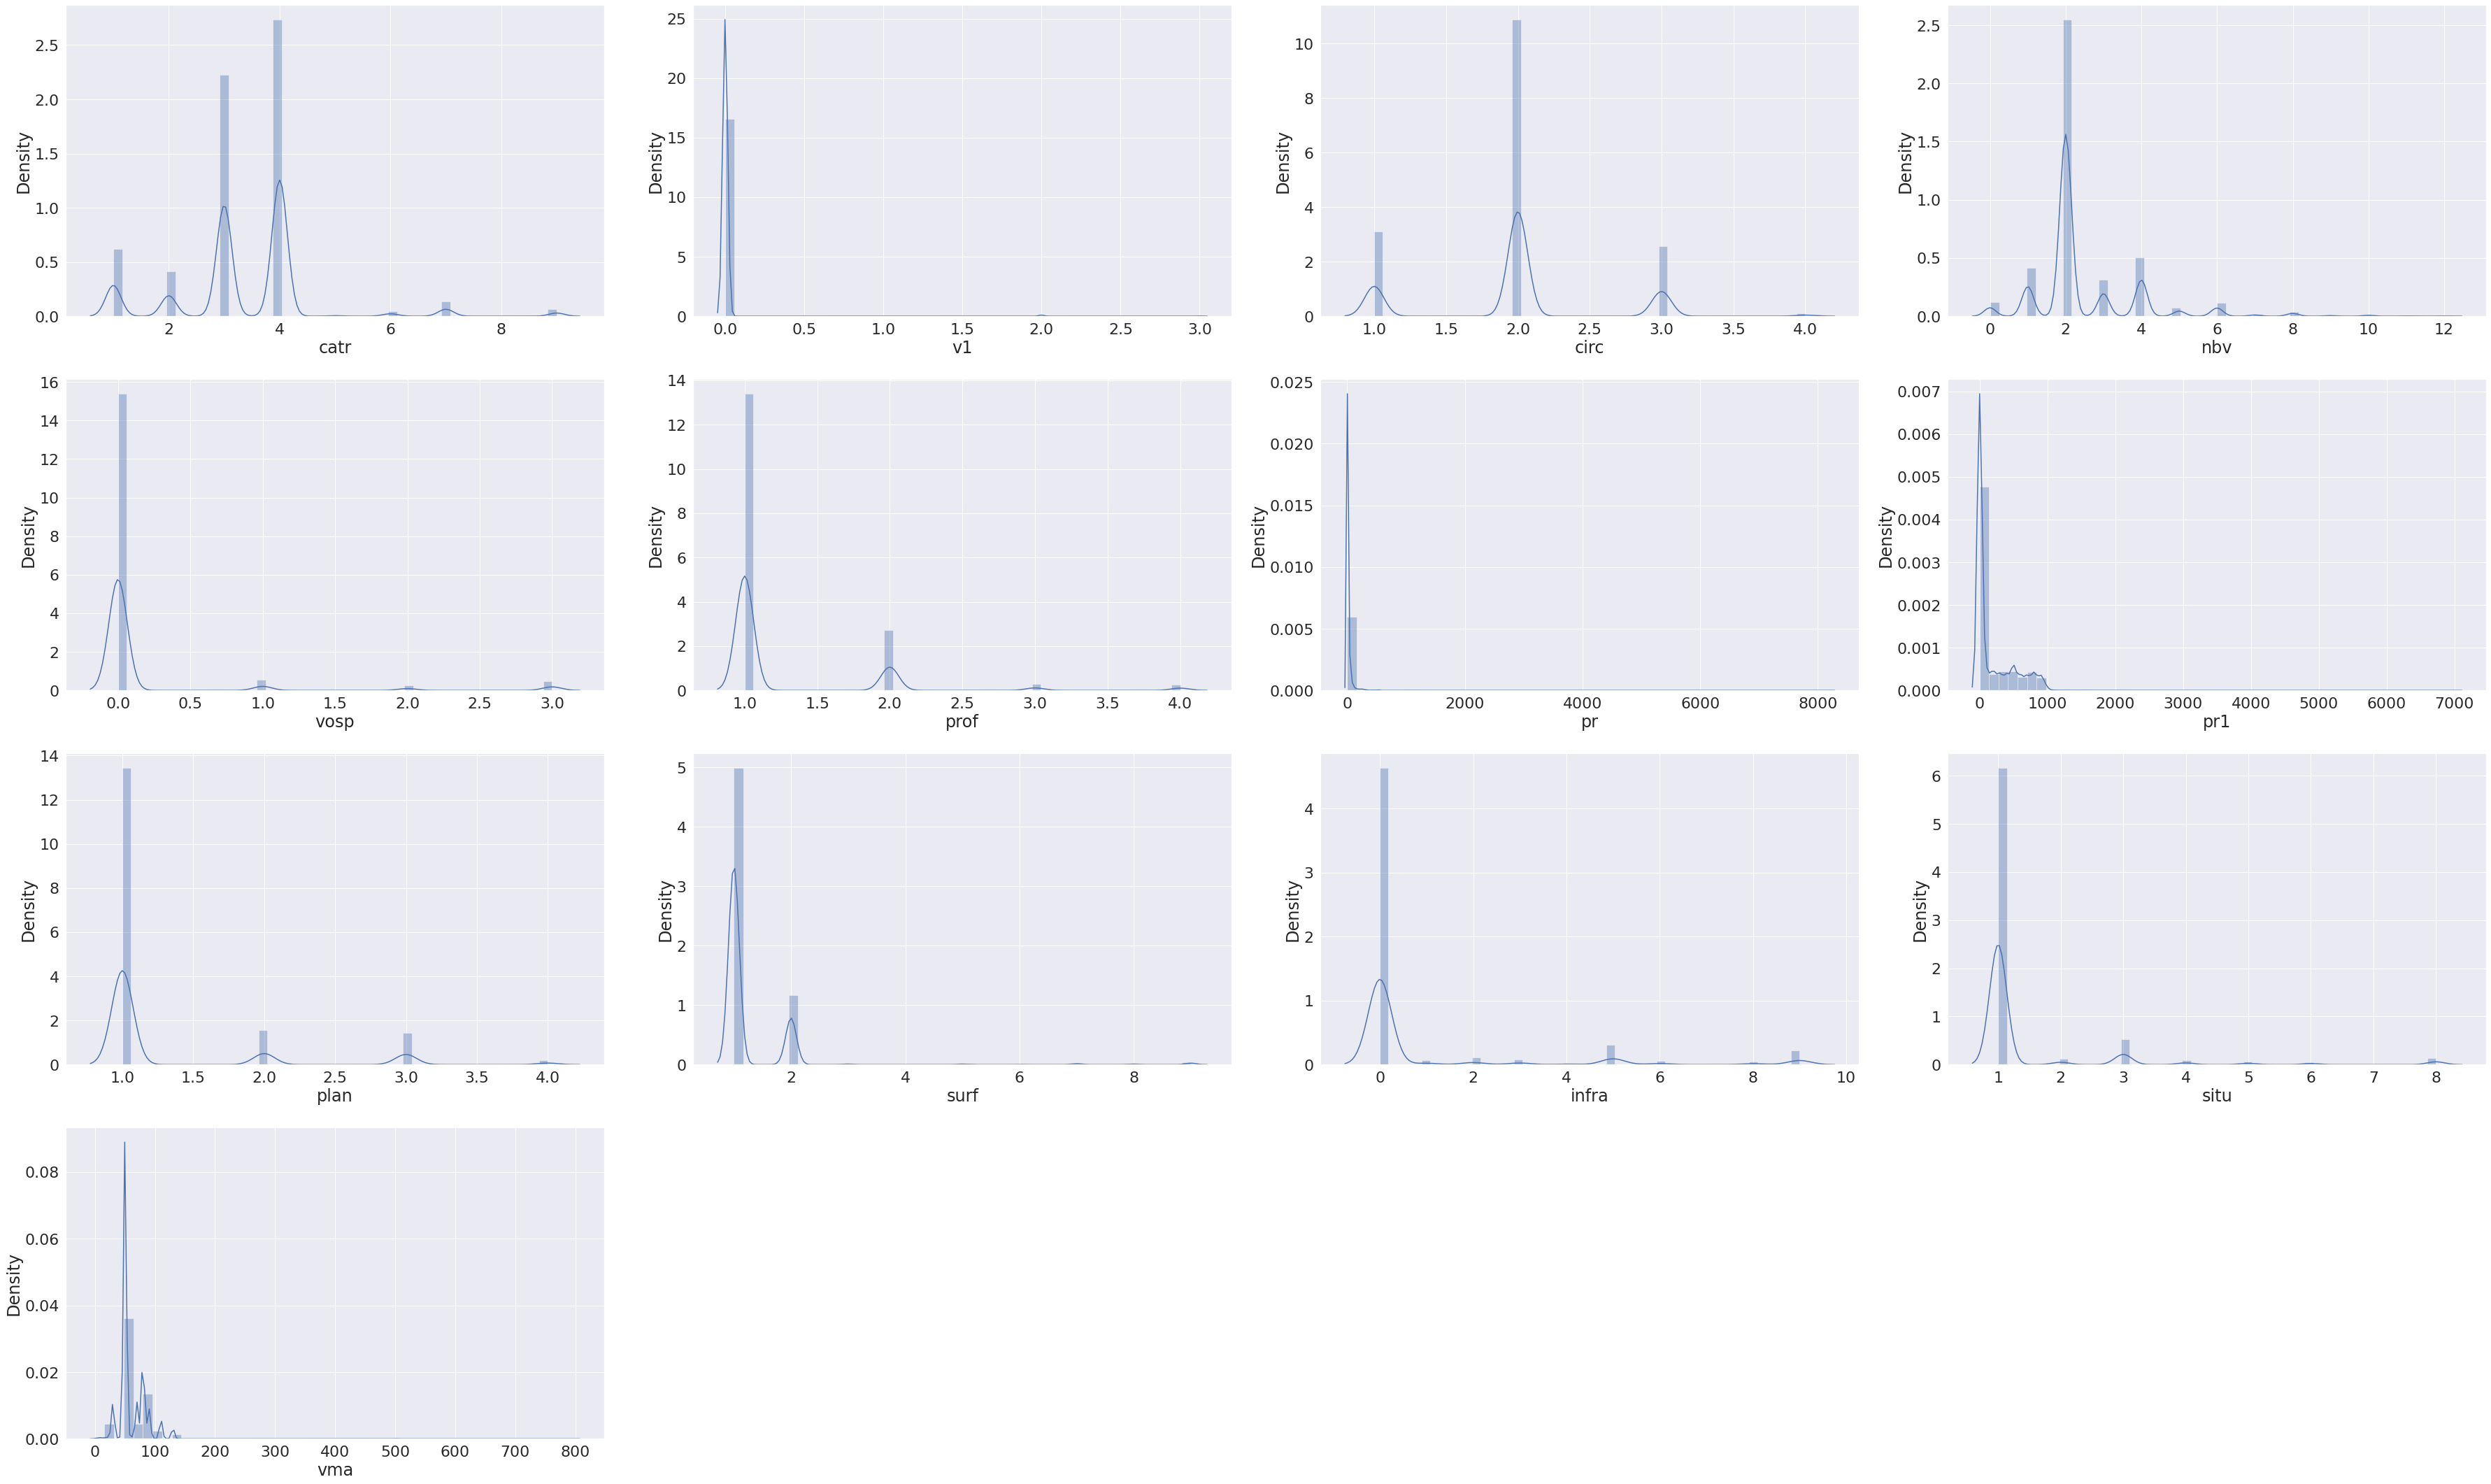

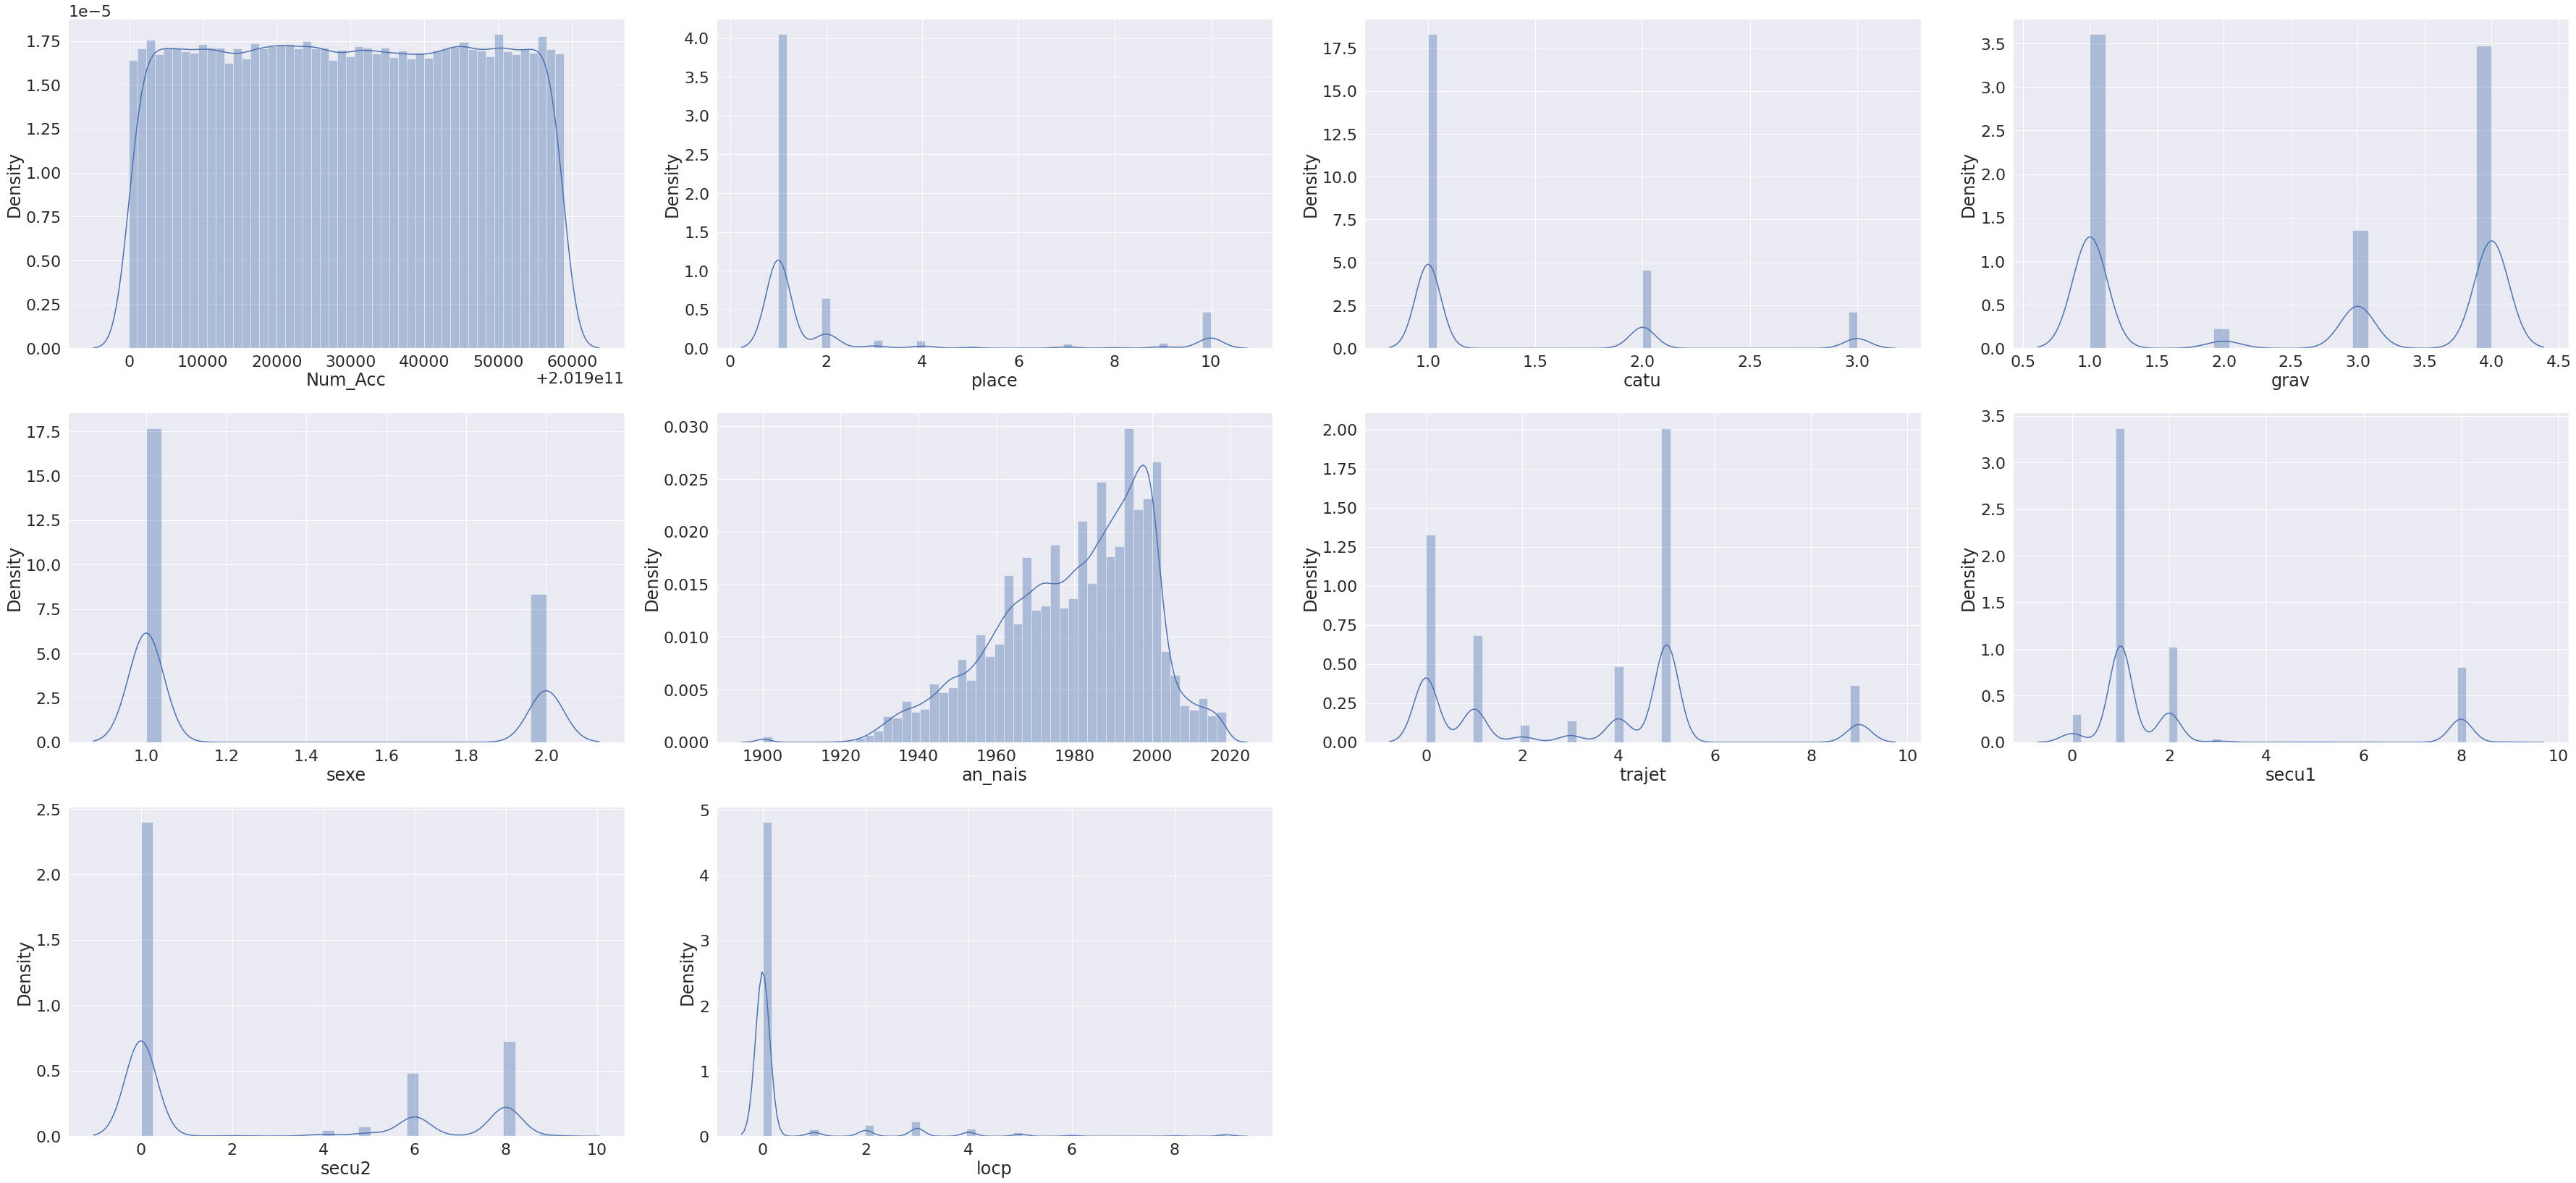

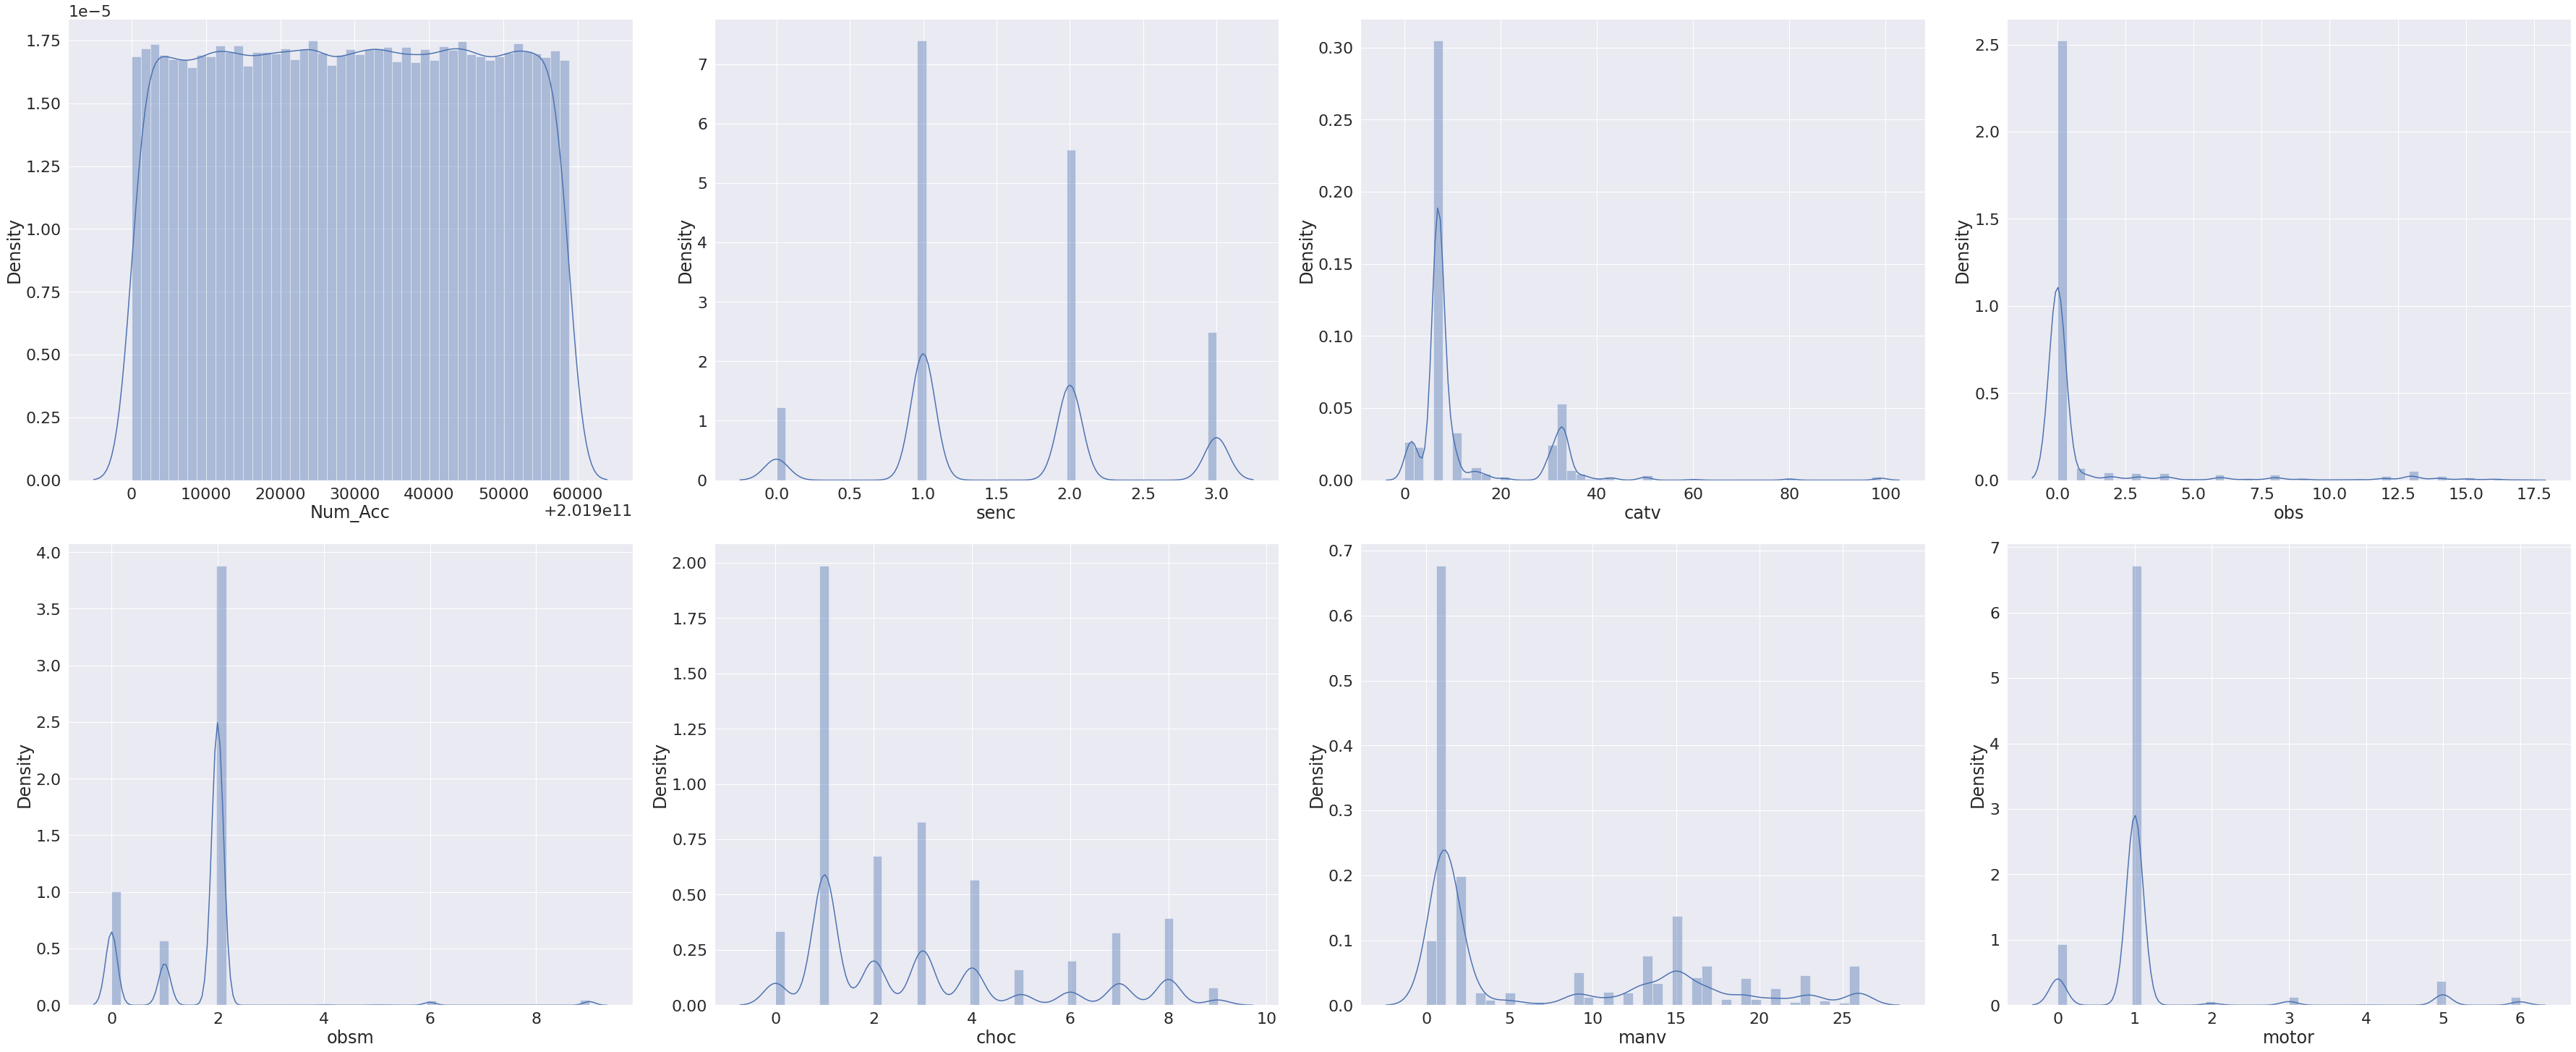

In [8]:
datasets = [chars, places, drivers, vehicles]

for df in datasets:
    sns.set(font_scale = 2)
    fig, ax = plt.subplots(math.ceil(df.shape[1]/4),4, figsize=(50, 30))
    i=0
    for col in df.select_dtypes(include=['float64','int64']):
        sns.distplot(df[col],label=col,ax=ax[i//4][i%4])
        i=i+1
        
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            if not ax[i][j].lines: ax[i][j].set_visible(False)
    fig.show()
    plt.tight_layout()

In [9]:
print(places['voie'].value_counts())

1                                  1106
86                                  862
7                                   827
6                                   824
4                                   799
                                   ... 
SCHILTIGHEIM                          1
CANIGOU AVENUE DU                     1
HAURANNNE (AVENUE DUVERGIER DE)       1
AVENUE JEAN BART                      1
Gabriel Péri (AV)                     1
Name: voie, Length: 14327, dtype: int64


In [10]:
print(chars['adr'].value_counts())

AUTOROUTE A86                        335
A4                                   300
AUTOROUTE A1                         285
AUTOROUTE A3                         276
AUTOROUTE A15                        250
                                    ... 
R DE L'ABBE HENOCQUE                   1
KENNEDY (AVENUE J.)N°PAIRS 2A2560      1
LAMARQUE (AV JEAN ALBERT)              1
ROUTE DES AMIS DE LA NATURE            1
Boulevard l'Alouette                   1
Name: adr, Length: 31934, dtype: int64


In [11]:
print(chars['com'].value_counts())

75116    629
75112    431
75117    424
31555    403
75119    401
        ... 
80136      1
67421      1
79259      1
59455      1
76462      1
Name: com, Length: 11421, dtype: int64


In [8]:
depcount=chars['dep'].value_counts()
print(depcount)

75     5610
93     3067
13     2997
94     2681
69     2521
       ... 
90       47
978      33
977      16
986      10
975       4
Name: dep, Length: 107, dtype: int64


75     5610
93     3067
13     2997
94     2681
69     2521
       ... 
90       47
978      33
977      16
986      10
975       4
Name: dep, Length: 107, dtype: int64


[]

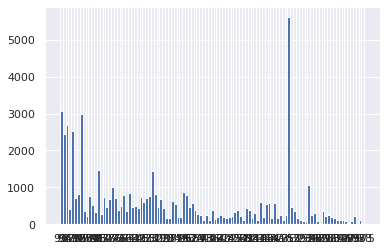

In [9]:
sns.set(font_scale = 1)
print(depcount)
plt.figure()
histogr=plt.hist(list(chars['dep'].values),bins=107)
plt.plot()

Παρατηρούμε ότι από όλα τα object το μόνο στο οποίο εμφανίζεται σχετικά περιορισμένος αριθμός διαφορετικών τιμών(107, ενώ στα υπόλοιπα οι διαφορετικές τιμές είναι πάνω από 10.000 και δεν μπορούν ούτε να ομαδοποιηθούν ούτε να συμβολιστούν με διανύσματα άρα η μόνη αντιμετώπιση που μπορούν να έχουν είναι να γίνουν drop καθώς αλλιώς θα αυξήσουν σε υπερβολικό βαθμό τις διαστάσεις τους dataset) είναι το dep, δηλαδή ο κωδικός του γεωγραφικού διαμερίσματος. Διαλέγουμε να ομαδοποιήσουμε τα dep σε 5 ομάδες με κωδικούς 0-4 ούτως ώστε όλες οι ομάδες να έχουν όσο το δυνατόν πιο κοντινούς αριθμούς εμφάνισης γίνεται. Μετά απο δοκιμές καταλήξαμε στο παρακάτω σχήμα ομαδοποίησης στο οποίο όλες οι ομάδες έχουν τιμές εμφάνισης σε εύρος τεσσάρων χιλιάδων.

In [10]:
depdict = dict(depcount)

for ind in chars.index:
    com1 = chars._get_value(ind, 'dep')
    if(com1 not in depdict):
        continue
    if (depdict[com1]>=2.5*1121):
        chars.at[ind, 'dep'] = 4
    elif(depdict[com1]>=1.2*1121):
        chars.at[ind, 'dep'] = 3
    elif(depdict[com1]>=0.63*1121):
        chars.at[ind, 'dep'] = 2
    elif(depdict[com1]>=0.41*1121):
        chars.at[ind, 'dep'] = 1
    else:
        chars.at[ind, 'dep'] = 0
print(chars['dep'].value_counts())

0    14815
4    11674
2    11521
3    10552
1    10151
Name: dep, dtype: int64


In [15]:
print(drivers['num_veh'].value_counts())

A01     80464
B01     44394
C01      5465
D01      1205
Z01       814
E01       292
F01       113
Y01        63
G01        47
H01        22
T01        17
I01        16
M01        11
K01        10
J01         8
L01         8
W01         4
Q01         4
X01         4
O01         3
N01         3
U01         2
MA01        2
V01         1
LB01        1
CB01        1
\01         1
VF01        1
P01         1
Name: num_veh, dtype: int64


In [16]:
print(vehicles['num_veh'].value_counts())

A01     57666
B01     35355
C01      4482
Z01      1666
D01       975
E01       244
F01        91
Y01        66
G01        34
H01        20
T01        19
I01        13
X01        10
L01         6
K01         6
M01         5
J01         5
ZZ01        3
N01         3
CB01        3
W01         3
O01         3
TB01        2
U01         2
P01         2
Q01         2
FB01        2
[01         2
LB01        1
ZB01        1
BB01        1
AA01        1
DA01        1
AB01        1
VF01        1
\01         1
VB01        1
BA01        1
RC01        1
MA01        1
GB01        1
R01         1
TC01        1
RA01        1
MB01        1
V01         1
PB01        1
BC01        1
Name: num_veh, dtype: int64


In [19]:
print(vehicles['obs'].value_counts())

0.0     86334
1.0      2314
13.0     1744
2.0      1483
3.0      1419
4.0      1376
6.0      1119
8.0      1094
14.0      798
12.0      735
15.0      537
16.0      399
9.0       395
7.0       304
11.0      213
5.0       163
17.0      134
10.0      108
Name: obs, dtype: int64


# Μετρική 

Χρησιμοποιούμε τη μετρική f1_Macro η οποία υπολογίζεται ως ο αριθμητικός μέσος όρος της ακρίβειας όλων των κλάσεων(4). Επιλέγουμε τη συγκεκτριμένη μετρική ώστε όλες οι κατηγορίες να αντιμετωπίζονται ισότιμα για να αξιολογηθεί η συνολική απόδοση του ταξινομητή σε σχέση με τις πιο συχνές ετικέτες κλάσεων, καθώς παρατηρήσαμε παρακάτω πως έχουμε μεγάλο imbalance στις τιμές των labels και οι σημαντικές κατηγορίες Heavily Injured και Killed κατέχουν τα λιγότερα samples. Επομένως, στοχεύουμε ώστε να βελτιώσουμε τα predictions αυτών των κλάσεων.

In [11]:
def evaluate_classifier(clf, X, y):
    f1_macro = cross_val_score(clf, X, y, 
        cv=KFold(n_splits=5, random_state=None),scoring="f1_macro", error_score="raise")
    #print(clf_name, "f1_macro:", np.mean(f1_macro), "%")
    return np.mean(f1_macro)

#evaluate_classifier(clf, X_train, y_train, "MLP")

# Data Cleaning
Για να προχωρήσουμε στην ταξινόμηση πρέπει αρχικά να επεξαργαστούμε τα δεδομένα μας με κατάλληλο τρόπο.Αρχικά κανονικοποιούμε δυο χαρακτηριστικά που έχουν πολύ μεγάλες τιμές. Έπειτα επιλέγουμε να αφαιρέσουμε κάποια χαρακτηριστικά από τα data_set, τα οποία δεν θα ωφελήσουν στη συνέχεια.

**Feature Drop**

Για το dataset Characteristiques:

Tο χαρακτηριστικό an, το οποίο είναι η χρονολογία των ατυχημάτων που όμως είναι ίδια για όλα τα δείγματα. 
Tο χαρακτηριστικό adr που είναι η διεύθυνση των ατυχημάτων, η οποία είναι κατηγορικά δεδομένα τα οποία δεν επαναλαμβάνονται και δεν μπορούν να χρησιμοποιοηθούν για την ταξινόμηση. 
Tο χαρακτηριστικό com που είναι ο δήμος που έγινε το τρακάρισμα διότι υπάρχει επικάλυψη με το χαρακτηριστικό dep(Department) που χρησιμοποιούμε.

Για το dataset lieux:

Το χαρακτηριστικό V1, το οποίο είναι ο αριθμητικός δείκτης του αριθμού του δρόμου και έχει σχεδόν σε όλα τα δείγματα την τιμή 0.
Το χαρακτηριστικό vosp, το οποίο υποδεικνύει την ύπαρξη δεσμευμένης λωρίδας, ανεξάρτητα από το αν το ατύχημα έγινε ή όχι σε αυτόν τον δρόμο και έχει και αυτό σε συντριπτικά μεγάλο ποσοστό τιμή 0 στα δείγματα.

Το χαρακτηριστικό voie, το οποίο αναφέρεται στον δρόμο του κάθε ατυχήματος που έχει αριθμητικές και κατηγορικές τιμές που δεν επαναλαμβάνονται και δεν μπορει να χρησιμοποιηθεί για την ταξινόμηση.

Για το dataset vehicules:

Το χαρακτηριστικό obs, το οποίο είναι το σταθερό εμπόδιο το οποίο χτυπήθηκε που το συντριπτικά μεγαλύτερο ποσοστό των τιμών είναι 0(not applicable) και δεν μας συμφέρει να το κρατήσουμε για την ταξινόμηση.

**Nan Values**

Βρίσκουμε εύκολα τις Nan τιμές του κάθε dataset και επιλέγουμε να τις αντικαταστήσουμε με τις πιο συχνα εμφανιζόμενες για το κάθε χαρακτηριστικό, διότι τα περισσότερα είναι μη διατεταγμένα χαρακτηριστικά και για παράδειγμα η αντιστοίχιση με μέσους όρους δεν θα είχε νόημα.

**Σύνδεση των dataset**

Με βάση τα indexes num_Acc και num_veh συνδέουμε τα dataset characteristiques-lieux και usagers-vehicules αντίστοιχα και στη συνέχεια τα δύο ενωμένα με το num_Acc. Παρατηρούμε ότι οι γραμμές δεν είναι ίσες σε όλα τα dataset, ενώ το num_Acc παίρνει τις ίδιες τιμές. Στα dataset που έχουν παραπάνω γραμμές επαναλαμβάνονται οι τιμές του num_Acc. Άρα κατά την ένωση των dataset στις γραμμές που επαναλαμβάνεται το ίδιο num_Acc θα μπουν οι ίδιες τιμές των χαρακτηριστικών από τα dataset που δεν επαναλαμβάνεται το num_Acc. Έτσι τελικά έχουμε ένα τελικό dataset το οποίο έχει γραμμές ίσες με το dataset που είχε πριν την ένωση τις περισσότερες(το usagers).

Σημείωση: Παρατηρούμε ότι βρίσκουμε και Nan values αφού κάνουμε την ένωση παρόλο που τα είχαμε πριν εξαλύψει. Αυτό πιθανώς βασίζεται στο ότι ο αριθμός των num_Acc είναι μεγαλύτερος από τις γραμμές που έχει ένα dataset(lieux), οπότε κατά την ένωση υπάρχουν γραμμές που δεν βρίσκουν αντιστοιχία με το num_Acc τους για κάποια χαρακτηριστικά.

**Κατηγορικά/Μη διατεταγμένα Δεδομένα**

Για να μπορέσουμε να προχωρήσουμε πρέπει να διαχειριστούμε τα κατηγορικά και τα μη διατεταγμένα δεδομένα. Ο καλύτερος τρόπος να το κάνουμε αυτό είναι μέσω της μεθόδου get_dummies() της pandas, η οποία μετατρέπει τις κατηγορικές/μη διατεταγμένες μεταβλητές σε ξεχωριστά  χαρακτηριστικά με τιμές ή 0 ή 1, όπου θα είναι μη μηδενική η τιμή του χαρακτηριστικού που είχε πριν το δείγμα.


In [12]:
chars = chars.drop(columns = ['an', 'adr', 'com'])
chars['lat'] = chars['lat']/10000000
chars['long'] = chars['long']/10000000
chars = chars.drop('201900033874',axis=0)

places = places.drop(columns = ['v1', 'vosp', 'pr', 'voie'])
vehicles = vehicles.drop(columns = ['obs'])

print("\nDataset characteristics has:", chars.shape[0], "rows and", chars.shape[1], "columns") 
print("Dataset places has:", places.shape[0], "rows and", places.shape[1], "columns") 
print("Dataset drivers has:", drivers.shape[0], "rows and", drivers.shape[1], "columns") 
print("Dataset vehicles has:", vehicles.shape[0], "rows and", vehicles.shape[1], "columns") 


Dataset characteristics has: 58839 rows and 12 columns
Dataset places has: 58814 rows and 11 columns
Dataset drivers has: 132977 rows and 13 columns
Dataset vehicles has: 100710 rows and 9 columns


In [13]:
print("NaN in dataset Chars:",np.sum(np.sum(chars.isna())))
print("NaN in dataset Places:",np.sum(np.sum(places.isna())))
print("NaN in dataset Drivers:",np.sum(np.sum(drivers.isna())))
print("NaN in dataset Vehicles:",np.sum(np.sum(vehicles.isna())))
# ind1 = chars.index
# col1 = chars.columns

# imp = SimpleImputer(missing_values=np.NaN,strategy='most_frequent')
# chars = pd.DataFrame(imp.fit_transform(chars))
# places = pd.DataFrame(imp.fit_transform(places))
# drivers = pd.DataFrame(imp.fit_transform(drivers))
# vehicles = pd.DataFrame(imp.fit_transform(vehicles))
# chars.index = ind1
# chars.columns = col1

chars = chars.fillna(chars.mode().iloc[0])
places = places.fillna(places.mode().iloc[0])
drivers = drivers.fillna(drivers.mode().iloc[0])
vehicles = vehicles.fillna(vehicles.mode().iloc[0])

print("\nAfter imputing NaN values:")
print("NaN in dataset Chars:",np.sum(np.sum(chars.isna())))
print("NaN in dataset Places:",np.sum(np.sum(places.isna())))
print("NaN in dataset Drivers:",np.sum(np.sum(drivers.isna())))
print("NaN in dataset Vehicles:",np.sum(np.sum(vehicles.isna())))


NaN in dataset Chars: 1400
NaN in dataset Places: 12482
NaN in dataset Drivers: 117609
NaN in dataset Vehicles: 531

After imputing NaN values:
NaN in dataset Chars: 0
NaN in dataset Places: 0
NaN in dataset Drivers: 0
NaN in dataset Vehicles: 0


In [14]:
df_acc = pd.concat([chars, places.reindex(chars.index)], axis=1)
display(df_acc)

df_veh = pd.concat([drivers, vehicles.reindex(drivers.index)], axis=1)
display(df_veh)

df_acc = df_acc.loc[:,~df_acc.columns.duplicated()] # Get rid of duplicates
df_veh = df_veh.loc[:,~df_veh.columns.duplicated()]

df_veh.reset_index(drop=True, inplace=True)
df_veh.index = df_veh['Num_Acc'].astype('str')
df_veh = df_veh.drop(['Num_Acc'],axis=1)
df = pd.concat([df_acc.reindex(df_veh.index),df_veh],axis=1)

print(df.dtypes)
df = df.drop(columns=['id_vehicule', 'num_veh'])
df=pd.get_dummies(df,columns=["lum","int","atm","col","catr","circ","dep", "prof", "place","plan","surf","infra","situ","senc","catv","obsm","choc","manv","motor","catu","trajet","secu1","secu2","locp","actp"])
display(df)
df = df.drop(columns=['Num_Acc'])
print(df.info())
print("NaN in final dataset:",np.sum(np.sum(df.isna())))
df = df.fillna(df.mode().iloc[0])
print("\nNaN in final dataset after imputing:",np.sum(np.sum(df.isna())))

,Num_Acc,jour,mois,hrmn,lum,dep,agg,int,atm,col,...,catr,circ,nbv,prof,pr1,plan,surf,infra,situ,vma
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,201900000001,30.0,11.0,0.062500,4.0,4,1.0,1.0,1.0,2.0,...,1.0,3.0,10.0,1.0,900.0,2.0,1.0,2.0,1.0,70.0
201900000002,201900000002,30.0,11.0,0.118056,3.0,4,1.0,1.0,1.0,6.0,...,1.0,1.0,2.0,4.0,845.0,2.0,1.0,0.0,1.0,70.0
201900000003,201900000003,28.0,11.0,0.635417,1.0,3,1.0,1.0,1.0,4.0,...,1.0,3.0,8.0,1.0,500.0,3.0,1.0,0.0,1.0,90.0
201900000004,201900000004,30.0,11.0,0.847222,5.0,3,1.0,1.0,1.0,4.0,...,1.0,3.0,5.0,1.0,299.0,1.0,1.0,0.0,1.0,90.0
201900000005,201900000005,30.0,11.0,0.166667,3.0,3,1.0,1.0,1.0,2.0,...,1.0,1.0,3.0,1.0,0.0,3.0,1.0,2.0,1.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201900058836,201900058836,30.0,11.0,0.375000,1.0,3,1.0,1.0,5.0,2.0,...,1.0,1.0,3.0,1.0,500.0,1.0,2.0,3.0,1.0,130.0
201900058837,201900058837,27.0,11.0,0.326389,1.0,2,1.0,1.0,8.0,4.0,...,1.0,1.0,2.0,1.0,282.0,1.0,2.0,0.0,1.0,90.0
201900058838,201900058838,30.0,11.0,0.111806,4.0,3,1.0,1.0,1.0,6.0,...,1.0,3.0,3.0,1.0,199.0,1.0,1.0,0.0,1.0,90.0


,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,...,actp,Num_Acc,id_vehicule,num_veh,senc,catv,obsm,choc,manv,motor
id_vehicule,,,,,,,,,,,,,,,,,,,,,
138 306 524,201900000001,138 306 524,B01,2,2,4,2,2002,0.0,1.0,...,0,201900000001,138 306 524,B01,2.0,7,2.0,5.0,23.0,1.0
138 306 524,201900000001,138 306 524,B01,1,1,4,2,1993,5.0,1.0,...,0,201900000001,138 306 524,B01,2.0,7,2.0,5.0,23.0,1.0
138 306 525,201900000001,138 306 525,A01,1,1,1,1,1959,0.0,1.0,...,0,201900000001,138 306 525,A01,2.0,17,0.0,3.0,11.0,1.0
138 306 523,201900000002,138 306 523,A01,1,1,4,2,1994,0.0,1.0,...,0,201900000002,138 306 523,A01,1.0,7,0.0,1.0,0.0,1.0
138 306 520,201900000003,138 306 520,A01,1,1,1,1,1996,0.0,1.0,...,0,201900000003,138 306 520,A01,1.0,7,2.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137 982 135,201900058837,137 982 135,C01,1,1,4,2,1988,1.0,1.0,...,0,201900058837,137 982 135,C01,1.0,7,2.0,1.0,2.0,1.0
137 982 132,201900058838,137 982 132,A01,1,1,4,1,1998,9.0,1.0,...,0,201900058838,137 982 132,A01,2.0,7,0.0,1.0,21.0,0.0
137 982 131,201900058839,137 982 131,A01,1,1,3,1,1979,0.0,2.0,...,0,201900058839,137 982 131,A01,2.0,33,0.0,7.0,1.0,1.0


Num_Acc         object
jour           float64
mois           float64
hrmn           float64
lum            float64
dep            float64
agg            float64
int            float64
atm            float64
col            float64
lat            float64
long           float64
catr           float64
circ           float64
nbv            float64
prof           float64
pr1            float64
plan           float64
surf           float64
infra          float64
situ           float64
vma            float64
id_vehicule     object
num_veh         object
place            int64
catu             int64
grav             int64
sexe             int64
an_nais          int64
trajet         float64
secu1          float64
secu2          float64
locp           float64
actp            object
senc           float64
catv             int64
obsm           float64
choc           float64
manv           float64
motor          float64
dtype: object


,Num_Acc,jour,mois,hrmn,agg,lat,long,nbv,pr1,vma,...,actp_2,actp_3,actp_4,actp_5,actp_6,actp_7,actp_8,actp_9,actp_A,actp_B
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,201900000001,30.0,11.0,0.062500,1.0,48.896210,2.470120,10.0,900.0,70.0,...,0,0,0,0,0,0,0,0,0,0
201900000001,201900000001,30.0,11.0,0.062500,1.0,48.896210,2.470120,10.0,900.0,70.0,...,0,0,0,0,0,0,0,0,0,0
201900000001,201900000001,30.0,11.0,0.062500,1.0,48.896210,2.470120,10.0,900.0,70.0,...,0,0,0,0,0,0,0,0,0,0
201900000002,201900000002,30.0,11.0,0.118056,1.0,48.930700,2.368800,2.0,845.0,70.0,...,0,0,0,0,0,0,0,0,0,0
201900000003,201900000003,28.0,11.0,0.635417,1.0,48.935872,2.319174,8.0,500.0,90.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201900058837,201900058837,27.0,11.0,0.326389,1.0,48.576900,7.726900,2.0,282.0,90.0,...,0,0,0,0,0,0,0,0,0,0
201900058838,201900058838,30.0,11.0,0.111806,1.0,48.771700,2.345760,3.0,199.0,90.0,...,0,0,0,0,0,0,0,0,0,0
201900058839,201900058839,30.0,11.0,0.638889,1.0,48.777289,2.223759,1.0,99.0,50.0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 132977 entries, 201900000001 to 201900058840
Columns: 241 entries, jour to actp_B
dtypes: float64(9), int64(3), uint8(229)
memory usage: 42.2+ MB
None
NaN in final dataset: 2385

NaN in final dataset after imputing: 0


# Train-Test Split 

Αποφασίσαμε να χωρίσουμε το dataset σε 80% train set και 20% test set, καθώς επειδή έχουμε λίγα δείγματα των κλάσεων Heavily Injured και Killed θέλουμε να έχουμε έναν σημαντικό αριθμό αυτών των δειγμάτων στο train set για να κάνουμε καλύτερο train. Επίσης, cross-validation θα χρησιμοποιηθεί μόνο στην βελτιστοποίηση, ενώ στο out-of-the-box θα γίνει αξιολόγηση στο test set. Το χρησιμοποιούμε για να δούμε καλύτερα πως γενικεύουν τα μοντέλα μας και να αποφύγουμε overfitting στο test set. Αποφασίσαμε να κάνουμε 5-fold CV.

In [15]:
y = df["grav"].values
print(type(y))
x=df.drop(columns=["grav"])
x=np.array(x)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, shuffle=True,random_state=42)

print(X_train.shape)
print(X_test.shape)
count_unharmed = np.sum([y == 1])
count_killed = np.sum([y == 2])
count_Injured_hospitalized = np.sum([y == 3])
count_Slightly_injured  = np.sum([y == 4])
a_priori_unharmed = count_unharmed / len(df) * 100
a_priori_killed = count_killed / len(df) * 100
a_priori_Injured_hospitalized = count_Injured_hospitalized / len(df) * 100
a_priori_Slightly_injured = count_Slightly_injured / len(df) * 100

print("\nDataset Balance")
print("Class_unharmed percentage: ", a_priori_unharmed, "%")
print("Class_killed percentage: ", a_priori_killed, "%")
print("Class_Injured_hospitalized percentage: ", a_priori_Injured_hospitalized, "%")
print("Class_Slightly_injured percentage: ", a_priori_Slightly_injured, "%\n")

print(X_train)
print(X_test)

<class 'numpy.ndarray'>
(106381, 240)
(26596, 240)

Dataset Balance
Class_unharmed percentage:  41.596667092805525 %
Class_killed percentage:  2.630530091669988 %
Class_Injured_hospitalized percentage:  15.685419283033909 %
Class_Slightly_injured percentage:  40.087383532490584 %

[[11.          1.          0.77777778 ...  0.          0.
   0.        ]
 [24.          7.          0.61458333 ...  0.          0.
   0.        ]
 [26.          4.          0.49305556 ...  0.          0.
   0.        ]
 ...
 [ 4.          2.          0.83125    ...  0.          0.
   0.        ]
 [24.         10.          0.35416667 ...  0.          0.
   0.        ]
 [30.          3.          0.22916667 ...  0.          0.
   0.        ]]
[[11.          8.          0.36458333 ...  0.          0.
   0.        ]
 [ 1.         11.          0.59027778 ...  0.          0.
   0.        ]
 [27.          7.          0.48958333 ...  0.          0.
   0.        ]
 ...
 [22.         10.          0.79166667 ...  0.     

In [16]:
count_unharmed = np.sum([y_train == 1])
count_killed = np.sum([y_train == 2])
count_Injured_hospitalized = np.sum([y_train == 3])
count_Slightly_injured  = np.sum([y_train == 4])
print(count_unharmed)
print(count_killed)
print(count_Injured_hospitalized)
print(count_Slightly_injured)
#sampler_dict = {1:10000, 2:1357, 3:8043, 4:10000}

44326
2802
16708
42545


Παρατηρούμε πως υπάρχει μεγάλο imbalance στις κλάσεις!

In [22]:
# ros = RandomOverSampler(random_state=42, sampling_strategy='all')
# X_train, y_train = ros.fit_resample(X_train, y_train)

# min_max_scaler = MinMaxScaler(feature_range=(0,1))
# X_train = min_max_scaler.fit_transform(X_train)
# X_test = min_max_scaler.transform(X_test)

# Επίδοση Out-of-the-Box

In [26]:
# pca = PCA(n_components=5)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

clf = MLPClassifier(random_state=1,max_iter=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.78      0.68      0.72     10988
           2       0.33      0.00      0.01       696
           3       0.44      0.55      0.49      4150
           4       0.61      0.68      0.64     10762

    accuracy                           0.64     26596
   macro avg       0.54      0.48      0.47     26596
weighted avg       0.65      0.64      0.64     26596



In [16]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.43      0.54      0.48     10988
           2       0.00      0.00      0.00       696
           3       0.00      0.00      0.00      4150
           4       0.46      0.55      0.50     10762

    accuracy                           0.45     26596
   macro avg       0.22      0.27      0.24     26596
weighted avg       0.36      0.45      0.40     26596



In [17]:
dummy_stratified = DummyClassifier(strategy="stratified")
model = dummy_stratified.fit(X_train, y_train)
predictions = dummy_stratified.predict(X_test)
dummy = f1_score(y_test, predictions, average = "macro")*100
print("Stratified f1_score:", dummy, "%")

Stratified f1_score: 25.4615604288454 %


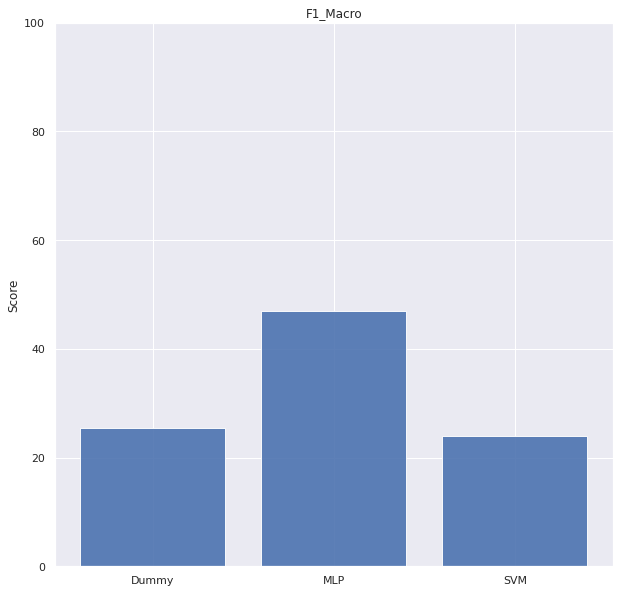

In [19]:
classifiers = ('Dummy', 'MLP', 'SVM')
f = plt.figure(1)
f.set_figwidth(10)
f.set_figheight(10)
y_pos = np.arange(3)
classifiers_f1 = [25.5, 47, 24]
plt.bar(y_pos, classifiers_f1, align='center', alpha=0.9)
plt.xticks(y_pos, classifiers)
plt.ylabel('Score')
plt.ylim([0, 100])
plt.title("F1_Macro")
plt.show()

| Estimator                       | Accuracy (%) | F1 Metric(Macro) (%) |
| :-------------------------:     |:-----------: | :-----------: |
| Dummy_Stratified | - | 25.5|
| MLP | 64 | 47 | 
| SVM | 45 | 24 |

**Σχολιασμός:**

Παρατηρούμε πως γενικότερα τα μοντέλα με τις default τιμές και χωρίς κανέναν μετασχηματισμό δεν έχουν καλές επιδόσεις. Ο MLP είναι με διαφορά ο καλύτερος με 47% F1 macro, ενώ ο SVM έχει παρομοία επίδοση με τον Dummy (!), που σημαίνει πως δεν κάνει καθόλου καλές εκτιμήσεις ειδικά στις *σημαντικές* κλάσεις. Επίσης, σημειώνεται πως ο SVM είναι σημαντικά πιο αργός από τον MLP (ωστόσο επειδή στον SVM κάναμε χρήση της GPU για να έχουμε αποτελέσματα σε λογικό χρόνο δεν είχε νόημα να τυπώσουμε τους χρόνους τρεξίματος).

Η κακή επίδοση του SVM, προφανώς οφείλεται αρχικά στο ότι η default τιμή του C είναι μικρή για το δεδομένο dataset (C=1) και επίσης τα δεδομένα δεν είναι scaled και υπάρχει μαγάλη ανομοιομορφία στις τιμές τους. Επίσης, λόγω του μεγάλου imbalance στα labels δεν πετυχαίνει καλές επιδόσεις στις μικρές κλάσεις. 

Σημαντικό είναι να σημειωθεί, πως είχαμε αρχικά χρησιμοποιήσει MinMaxScaler και Oversampler εδώ, πριν κάνουμε βελτιστοποίηση, για να σιγουρευτούμε ότι ο SVM λειτουργεί σωστά. Ωστόσο, διαπιστώσαμε πως είναι λάθος να κάνουμε Oversampling πριν κάνουμε Cross-Validation, γιατί με αυτό τον τρόπο πληροφορία από το train set περνάει στο validation set που θα προκύψει μετά το σπάσιμο στο CV και έτσι οι επιδόσεις του CV ήταν υψηλές, αλλά δεν ήταν αντιπροσωπευτικές 

Ο MLP από την άλλη έχει καλύτερες επιδόσεις και τα πηγαίνει πολύ καλύτερα στο classification όλων των κλάσεων εκτός του Killed. Επίσης, δεν επηρεάζεται σημαντικά από τα δεδομένα που δεν είναι scaled. 

# Βελτιστοποίηση

In [34]:
import optuna

def objective(trial):

    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 30, 60, step=2))
    
    activation_ = trial.suggest_categorical('activation', ['relu', 'tanh'])
    learning_rate_ = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
    #comps = trial.suggest_int('n_components', 200, 250, step=10)
    clf = MLPClassifier(random_state=1,max_iter=100, hidden_layer_sizes=tuple(layers), activation=activation_, learning_rate=learning_rate_,early_stopping=True)
    #pca = PCA(n_components=comps)
    ros = RandomOverSampler(random_state=42, sampling_strategy='all')
    min_max_scaler = MinMaxScaler(feature_range=(0,1))

    pipe = Pipeline(steps=[('ros',ros), ('scaler',min_max_scaler), ('mlp', clf)], memory='tmp')
    f1_score_ = evaluate_classifier(pipe, X_train, y_train)
    return f1_score_

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print(optuna.importance.get_param_importances(study))

[I 2022-11-28 10:32:38,733] A new study created in memory with name: no-name-52fc588e-9c17-43af-9898-7380a38b01a7
[I 2022-11-28 10:46:25,719] Trial 0 finished with value: 0.4939393299562559 and parameters: {'n_layers': 1, 'n_units_0': 50, 'activation': 'relu', 'learning_rate': 'constant'}. Best is trial 0 with value: 0.4939393299562559.
[I 2022-11-28 11:06:39,720] Trial 1 finished with value: 0.48914648938471617 and parameters: {'n_layers': 2, 'n_units_0': 36, 'n_units_1': 40, 'activation': 'tanh', 'learning_rate': 'constant'}. Best is trial 0 with value: 0.4939393299562559.
[I 2022-11-28 11:26:47,401] Trial 2 finished with value: 0.490962859316323 and parameters: {'n_layers': 2, 'n_units_0': 34, 'n_units_1': 50, 'activation': 'tanh', 'learning_rate': 'constant'}. Best is trial 0 with value: 0.4939393299562559.
[I 2022-11-28 11:44:14,781] Trial 3 finished with value: 0.48943415325475614 and parameters: {'n_layers': 1, 'n_units_0': 52, 'activation': 'tanh', 'learning_rate': 'constant'}.

OrderedDict([('activation', 0.3664550097639089), ('n_layers', 0.2970251363494888), ('n_units_0', 0.2741492358710442), ('learning_rate', 0.0623706180155581)])


In [ ]:
def objective(trial):

    C_values = trial.suggest_float('C_val', 1E6, 1E8, log=True)
    kernel_types = trial.suggest_categorical('kernels', ['rbf', 'poly'])
    gamma_values = trial.suggest_categorical('gamma_val', ['auto', 'scale'])
    degree_val = trial.suggest_int('degrees', 3, 7)
    #tol_val = trial.suggest_float('tols', )

   # sampler_dict = {1:7500, 2:750, 3:1100, 4:7300}
    #ros = RandomUnderSampler(sampling_strategy=sampler_dict)
    ros = RandomOverSampler(random_state=42, sampling_strategy='all')
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    clf = SVC(kernel=kernel_types, C=C_values, gamma=gamma_values, degree=degree_val)
    pipe = Pipeline(steps=[('ros',ros), ('scaler',min_max_scaler), ('svc', clf)], memory='tmp')
    f1score = evaluate_classifier(pipe, X_train, y_train)

    return f1score

study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective, n_trials=35)
print(optuna.importance.get_param_importances(study_svm))

[I 2022-11-27 17:21:51,997] A new study created in memory with name: no-name-3af0efbf-faf7-449d-b0ee-ab50db73ba71
[I 2022-11-27 18:44:11,842] Trial 0 finished with value: 0.4596207263755619 and parameters: {'C_val': 1500665.404305061, 'kernels': 'poly', 'gamma_val': 'auto', 'degrees': 3}. Best is trial 0 with value: 0.4596207263755619.
[I 2022-11-27 18:52:37,427] Trial 1 finished with value: 0.4528345511780981 and parameters: {'C_val': 95807896.31019583, 'kernels': 'poly', 'gamma_val': 'scale', 'degrees': 6}. Best is trial 0 with value: 0.4596207263755619.
[I 2022-11-27 20:18:47,469] Trial 2 finished with value: 0.4448623845563925 and parameters: {'C_val': 4790845.672461002, 'kernels': 'poly', 'gamma_val': 'scale', 'degrees': 3}. Best is trial 0 with value: 0.4596207263755619.
[I 2022-11-27 20:44:18,713] Trial 3 finished with value: 0.44871619237152877 and parameters: {'C_val': 11888708.855343563, 'kernels': 'poly', 'gamma_val': 'scale', 'degrees': 4}. Best is trial 0 with value: 0.459

# Τεκμηρίωση της διαδικασίας

Για την βελτιστοποίηση των μοντέλων μας χρησιμοποιήσαμε την βιβλιοθήκη Optuna.

Αρχικά θα κάνουμε preprocessing με τη χρήση MinMaxScaling και Oversampling, καθώς οι κλάσεις έχουν μεγάλο imbalance στο dataset και συγκεκριμένα οι κλάσεις: Killed και Heavily Injured ήταν μόλις το 2.3% και 14% του dataset αντίστοιχα, ενώ οι άλλες 2 κλάσεις που είναι και μικρότερου ενδιαφέροντος για τον σκοπό μας (Unharmed, Slightly Injured) είναι στο 45% και 39% αντίστοιχα. Επομένως με το Random Oversampling εξισορροπούμε το Dataset και έχουμε καλύτερα αποτελέσματα στις κλάσεις Killed, Heavily Injured που μας ενδιαφέρουν περισσότερο. Επίσης, τα χαρακτηριστικά όπως είδαμε στην αρχή έχουν μεγάλη ανομοιομορφία και κάποια από αυτά είναι αριθμητικά, ενώ άλλα έχουν μεν ακέραια μορφή, ωστόσο είναι διακριτά και μη διατεταγμένα. Επομένως, το scaling προσδίδει μια καλύτερη ομοιομορφία στα δεδομένα, πράγμα που βελτιώνει τα αποτελέσματα μας.

Ορίσαμε επομένως Pipelines που συμπεριλαμβάνουν τους μετασχηματιστές που αναφέραμε παραπάνω και τους classifiers που θέλουμε.

Δημιουργούμε trials με την χρήση του objective της optuna και κάνουμε αναζήτηση των βέλτιστων υπερπαραμέτρων. Ως επίδοση που θέλουμε να μεγιστοποίησουμε θεωρούμε το F1 macro με 5-fold cross validation στο Train Set.

**MLP:**
Στον MLP κάναμε αρχικά αναζήτηση στα number of layers, units of each layer, activation func και βήμα εκμάθησης. Αρχικά, είχαμε μεγάλα διαστήματα και μεγάλα βήματα με λίγα trials, ώστε να δούμε που περίπου έχουμε τα καλύτερα αποτελέσματα. Βάλαμε λίγα trials και με τη χρήση του optuna.importance.get_param_importances είδαμε ποιες είναι οι πιο σημαντικές παράμετροι που δημιοργούν αισθητή βελτίωση στην επίδοση. 
Αρχικά, όπως ήταν αναμενόμενο, τη μεγαλύτερη διαφορά έκαναν τα number of layers και units of each layer. Οι συναρτήσεις activation δεν προκαλούσαν όλες αλλαγές και επομένως τελικά περιοριστήκαμε στις relu, tanh, όπου και αυτές μεταξύ τους δεν έχουν μεγάλη διαφορά στην επίδοση. Το learning rate δεν δημιουργούσε σχεδόν καθόλου αλλαγές. Είδαμε πως τις καλύτερες επιδόσεις τις έχουμε για μικρό αριθμό από layers, στο διάστημα 1-3, ενώ οι νευρώνες κάθε layer φαίνεται πως είναι επιθυμητό να είναι στο διάστημα 30-60. Επομένως περιορίσαμε την αναζήτηση σε no. layers από 1 έως 3 και νευρώνες 30 έως 60 με βήμα 2.

**SVM:**
Στον SVM κάναμε αρχικά αναζήτηση στις τιμές των C, degrees, καθώς και στα kernel functions και gamma. Αρχικά με μεγάλο διάστημα του C και των degrees με μεγαλύτερο βήμα και σαν kernels είχαμε rbf, poly, sigmoid. Επιλέξαμε τον rbf, γιατί είναι καλός σε high dimensional data, ο sigmoid λειτουργεί σαν νευρωνικό και ο polynomial, για να δοκιμάσουμε και ένα πιο γενικό γραμμικό kernel function. Στο gamma έχουμε τις επιλογές auto και scale. Παρατηρήσαμε με λίγα trials και ξανά με το optuna.importance.get_param_importances πως οι σημαντικότερες υπερπαράμετροι είναι οι C, kernel, degrees, ενώ το gamma δεν έπαιζει πολύ ρόλο. Το C, όπως ήταν αναμενόμενο είχε την μεγαλύτερη επίδραση και έδινε τα καλύτερα αποτελέσματα σε μεγάλες τιμές (10^6 και πάνω). Επίσης, είδαμε πως ο sigmoid kernel δεν έδινε καλά αποτελέσματα και τον αφεραίσαμε, ενώ οι rbf και poly δεν έχουν μεγάλες διαφορές, ωστόσο ο poly δίνει καλύτερα αποτελέσματα. Επίσης το degree έδινε καλύτερα αποτελέσματα για τιμές μεγαλύτερες από 3. Επομένως, στη συνέχεια μειώσαμε το διάστημα των C και των degrees και παρατηρούμε πολύ μεγάλη βελτίωση.

(Να σημειωθεί πως βάση του optuna, πρέπει ο αριθμός των trial να είναι 100-1000, ωστόσο το kaggle βάζει χρονικό όριο στο notebook και δεν είναι δυνατό να τρέξουμε τόσα trials. Επίσης, παρατηρήσαμε πως γενικά μετά τα 10 trials δεν υπάρχει μεγάλη διαφορά στα αποτελέσματα.)

# Παρουσίαση αποτελεσμάτων

In [36]:
optuna.visualization.plot_optimization_history(study)

Μετά από τη βελτιστοποίηση με το optuna παρατηρήσαμε πως οι καλύτερες τιμές F1 score που μπορούμε να πετύχουμε είναι γύρω στο 50%. Ο MLP είναι καλύτερος του SVM και εδώ, ωστόσο ο SVM πλέον κάνει πιο λογικές προβλέψεις και πλησιάζει και αυτός το 50% με τις κατάλληλες παραμέτρους, αλλά και τους μετασχηματισμούς. Βλέπουμε και στο γράφημα από πάνω, τα trials του optuna για την βελτιστοποίηση του MLP και συμπεραίνουμε πως δεν υπάρχει πλέον μεγάλη διακύμανση στα scores μιας και περιορίσαμε τα διαστήματα αναζήτησης. Παρατηρούμε επίσης, πως το MLP βελτιστοποιείται για μόνο 2 hidden layers με λίγους σχετικά νευρώνες (56 και 30). Από την άλλη, ο SVM βελτιστοποιείται για σχετικά μεγάλη τιμή του C, πράγμα το οποίο δείχνει πως οι κλάσεις μας είναι αρκετά <<κοντά>> με βάση τα χαρακτηριστικά τους και είναι δύσκολο να διαχωριστούν από τον SVM. Επίσης, επιβεβαιώνεται πως ο SVM λειτουργεί καλύτερα με δεδομένα που είναι στο ίδιο διάστημα (scaled), καθώς προηγουμένως η επίδοση ήταν πολύ κακή, ενώ τώρα είναι πολύ κοντά σε αυτή του MLP

In [23]:
best_mlp = MLPClassifier(early_stopping=True, hidden_layer_sizes=(56,30), activation='relu', learning_rate='adaptive',random_state=1,max_iter=100)
ros = RandomOverSampler(random_state=42, sampling_strategy='all')
min_max_scaler = MinMaxScaler(feature_range=(0,1))
pipe = Pipeline(steps=[('ros',ros), ('scaler',min_max_scaler), ('mlp', best_mlp)], memory='tmp')
pipe.fit(X_train, y_train)

Pipeline(memory='tmp',
         steps=[('ros',
                 RandomOverSampler(random_state=42, sampling_strategy='all')),
                ('scaler', MinMaxScaler()),
                ('mlp',
                 MLPClassifier(early_stopping=True, hidden_layer_sizes=(56, 30),
                               learning_rate='adaptive', max_iter=100,
                               random_state=1))])

In [24]:
preds_mlp = pipe.predict(X_test)
print(classification_report(y_test, preds_mlp))

              precision    recall  f1-score   support

           1       0.74      0.76      0.75     10988
           2       0.17      0.23      0.20       696
           3       0.40      0.56      0.47      4150
           4       0.67      0.54      0.60     10762

    accuracy                           0.63     26596
   macro avg       0.50      0.52      0.50     26596
weighted avg       0.65      0.63      0.63     26596



Confusion Matrix of MLP:


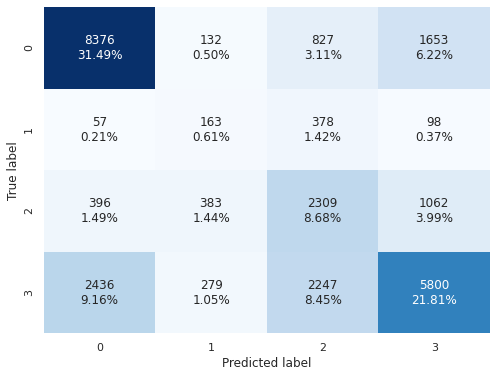

In [25]:
print("Confusion Matrix of MLP:")
cf_matrix = confusion_matrix(y_test, preds_mlp)
make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=False)

In [18]:
best_svm = SVC(C=1874169.2308740001, degree=5, gamma='auto', kernel='poly')
ros = RandomOverSampler(random_state=42, sampling_strategy='all')
min_max_scaler = MinMaxScaler(feature_range=(0,1))
pipe = Pipeline(steps=[('ros',ros), ('scaler',min_max_scaler), ('svm', best_svm)], memory='tmp')
pipe.fit(X_train, y_train)
preds_svm = pipe.predict(X_test)
print(classification_report(y_test, preds_svm))

              precision    recall  f1-score   support

           1       0.72      0.73      0.72     10988
           2       0.23      0.17      0.20       696
           3       0.41      0.41      0.41      4150
           4       0.61      0.61      0.61     10762

    accuracy                           0.62     26596
   macro avg       0.49      0.48      0.48     26596
weighted avg       0.61      0.62      0.61     26596



Confusion Matrix of SVM:


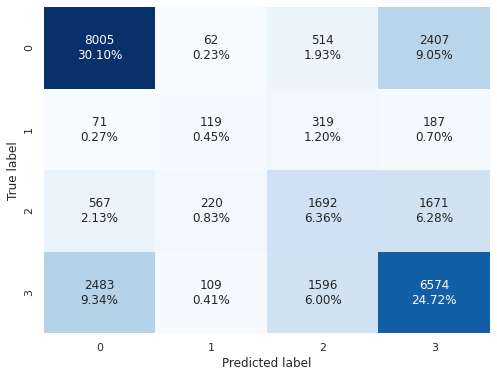

In [20]:
print("Confusion Matrix of SVM:")
cf_matrix = confusion_matrix(y_test, preds_svm)
make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=False)

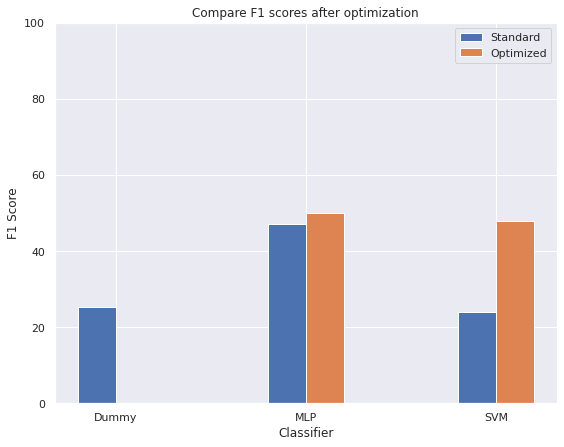

In [20]:
classifiers = ['Dummy', 'MLP', 'SVM']
fig, ax = plt.subplots(figsize=(9,7))
y_pos = np.arange(len(classifiers))
bar_width = 0.2
classifiers_f1_score = [25.2, 47, 24]
opt_f1 = [0, 50, 48]
acc_old = ax.bar(y_pos, classifiers_f1_score[-3:], bar_width, label="Standard")

acc_opt = ax.bar(y_pos + bar_width, opt_f1, bar_width, label="Optimized")

ax.set_xlabel('Classifier')
ax.set_ylabel('F1 Score')
ax.set_title('Compare F1 scores after optimization')
ax.set_xticklabels(classifiers)
ax.set_xticks(y_pos + bar_width / 2)
ax.legend()
plt.ylim([0, 100])
plt.show()

Παρατηρούμε από τα confusion matrices πως υπάρχει αρκετά μεγάλη σύγχυση στα labels που έχουν λίγα samples, δηλαδή στις κλάσεις 1 και 2 (Killed και Heavily Injured). Ο MLP καταφέρνει να κατατάξει περισσότερα δείγματα αυτών των κλάσεων στη σωστή κλάση. Κυρίως, οι ταξινομητές κατατάσσουν λανθασμένα στην κλάση heavily injured δείγματα της κλάσης killed, ενώ κατατάσσουν λανθασμένα κάποια heavily injured σε slightly injured. 

Ωστόσο, είναι σημαντικό να σημειωθεί πως πριν την βελτιστοποίηση και ο MLP και ο SVM είχαν ελάχιστο F1 score στην κλάση Killed (1%), ενώ μετά την εύρεση των βέλτιστων υπερπαραμέτρων και τους μετασχηματισμούς φτάνουν το 20%. Σε αυτό συνέβαλε σημαντικά και το Oversampling, καθώς και η αύξηση της υπεραμέτρου C στον SVM.

Όσον αφορά τους χρόνους εκτέλεσης, όπως αναφέρθηκε και παραπάνω, ο SVM είναι σημαντικά πιο αργός, αφού λόγω του kernel function αποθηκεύεται ένας ΝxΝ πίνακας σε κάθε σημείο της εκπαίδευσης. Δεν παρατίθενται οι χρόνοι, γιατί ο SVM έτρεξε σε GPU και επομένως δεν θα ήταν αντικειμενική η σύγκριση μεταξύ τους.

# Συμπεράσματα

Συμπεραίνουμε πως το Dataset αντικατοπτρίζει ένα αρκετά δύσκολο πρόβλημα και, όπως επιβεβαίωνεται και από την βιβλιογραφία, δεν επιτυγχάνονται υψηλές επιδόσεις 

Αν και σε γενικές γραμμές ο SVM πετυχαίνει καλύτερες επιδόσεις από τον MLP, καθώς βελτιστοποιούν τα όρια μεταξύ των κλάσεων και γενικεύουν καλύτερα, στο συγκεκριμένο πρόβλημα, τα δεδομένα είναι περίπλοκα, πολλά είναι αλληλοεξαρτούμενα και υπάρχει μεγάλος <<θόρυβος>> όπως είδαμε στην επισκόπηση του dataset. Επίσης, έχουμε μεγάλο imbalance και πολλά δεδομένα (με oversampling ξεπερνούν τα 150 χιλιάδες) με αποτέλεσμα ο MLP να μπορεί να διαχειριστεί καλύτερα τον θόρυβο δημιουργώντας την δική του γραμμική αναπαράσταση. Ο SVM χρησιμοποιεί τις προκαθορισμένες συναρτήσεις πυρήνα ώστε να απεικονίσουν τα δεδομένα εισόδου σε μεγαλύτερες διαστάσεις και να κάνουν τον διαχωρισμό.   

Επίσης, είδαμε πως ο MLP λειτουργούσε πολύ καλύτερα και χωρίς κανέναν μετασχηματισμό και καμία βελτιστοποίηση, ενώ στο βέλτιστο μοντέλο έχουμε μόνο 2 layers με σχετικά λίγους νευρώνες.

Τελικά, καταλήγουμε πως **η κατάλληλη επιλογή εδώ είναι ο MLP**, καθώς έχει και καλύτερες επιδόσεις, αλλά τρέχει και σημαντικά πιο γρήγορα από τον SVM, ενώ βελτιστοποιείται με μικρότερο αριθμό trials κατά μέσο όρο. 